In [1]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import torch.nn.functional as F
loss_func = torch.nn.MSELoss()

In [2]:
ratings = pd.read_pickle('movie_ratings_500_id.pkl')
films = pd.read_pickle('movie_metadata.pkl')

In [3]:
row = []
for mid,haha in ratings.items():
    for info in haha:
        info['movie'] = mid
        row.append(info)
df_ratings = pd.DataFrame(row)


row = []
for mid,haha in films.items():
    haha['movie'] = mid
    row.append(haha)
df_movie = pd.DataFrame(row)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
final = pd.merge(df_movie,df_ratings,on='movie')
a = final['user_id'].value_counts()[final['user_id'].value_counts() >= 10]
final = final[final['user_id'].isin(list(a.index))]
final.index = range(len(final))
hehe = final.copy()
del hehe['title']
del hehe['user_rating_date']

In [6]:
movie = dict()
for i in range(df_movie.shape[0]):
    m = df_movie['movie'][i]
    movie.setdefault(m,dict())
    movie[m]['director'] = df_movie['director'][i]
    movie[m]['genre'] = df_movie['genre'][i]
    movie[m]['actors'] = df_movie['actors'][i]
    movie[m]['title'] = df_movie['title'][i]

In [7]:
def map_aspect_values_to_movies(x):
    (film, meta), aspect = x
    aspects = dict()
    if aspect == "director":
        aspects[meta[aspect]] = 1
    else:
        for g in meta[aspect]:
            aspects[g] = 1
    return film, meta, aspects


def dict_movie_aspect(paper_films, aspect):
    paper_films_aspect_prepended = map(
        lambda e: (e, aspect), list(paper_films.items()))
    aspect_dict = dict()
    with ProcessPoolExecutor(max_workers=THREADS) as executor:
        results = executor.map(map_aspect_values_to_movies,
                               paper_films_aspect_prepended)
    for film, meta, aspects in results:
        aspect_dict[film + "_" + meta["title"]] = aspects
    return aspect_dict

In [8]:
movie_genres = dict_movie_aspect(movie, "genre")
movie_directors = dict_movie_aspect(movie,'director')
movie_actors = dict_movie_aspect(movie,'actors')
actors = pd.DataFrame.from_dict(movie_actors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
directors = pd.DataFrame.from_dict(movie_directors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
genres = pd.DataFrame.from_dict(movie_genres,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

In [9]:
actors_dict = dict(zip(actors, range(len(actors))))
directors_dict = dict(zip(directors, range(
    len(actors), len(actors) + len(directors))))
genres_dict = dict(zip(genres, range(
    len(actors) + len(directors), len(actors) + len(directors) + len(genres))))
# max(actors_dict.values()),max(directors_dict.values()),max(genres_dict.values())

In [10]:
def change_director(x):
    return [itemgetter(x)(directors_dict)]


def change_actor(x):
    return change_list((itemgetter(*x)(actors_dict)))


def change_genre(x):
    qunima = itemgetter(*x)(genres_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return change_list(qunima)


def change_list(x):
    return list(x)

In [11]:
hehe['director'] = hehe['director'].map(change_director)
hehe['actors'] = hehe['actors'].map(change_actor)
hehe['genre'] = hehe['genre'].map(change_genre)

In [12]:
hehe = hehe[['user_id','movie','actors','director','genre','user_rating']]
hehe['user_rating'] = hehe['user_rating'].astype('float')

In [13]:
le = LabelEncoder()
y = le.fit_transform(hehe['user_id'])
hehe['user_id'] = y

y = le.fit_transform(hehe['movie'])
hehe['movie'] = y


In [14]:
print("The number of aspects is {}".format(max(genres_dict.values()) + 1))
print("The number of users is {}".format(max(hehe['user_id'])+1))

The number of aspects is 1154
The number of users is 5128


In [15]:
print("The number of items is {}".format(len(hehe['movie'].value_counts())))

The number of items is 528


In [16]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.0)

def calculate_score(x, users, aspects):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base)
    actors_base = aspects(actor_base)  # 3 * 8
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)
        

    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''
        
        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [74]:
def RMSE(data, model,batch_size):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    
    return rmse ** 0.5,mae, cnm

In [75]:
def train(lr, dim, reg, batch_size, num_epochs, data, test):
    model = aspect_augumentation(5128, 1154, 3, dim).to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr,weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, threshold_mode='abs',threshold = 0.005)
    for epoch in range(num_epochs):
        model.train()
        t1 = time.time()
        num_example = len(data)
        indices = list(range(num_example))
        for i in tqdm(range(0, num_example, batch_size)):
            optimizer.zero_grad()
            indexs = indices[i:min(i+batch_size, num_example)]
            users_index = data.iloc[:, 0].loc[indexs].values
            users = torch.LongTensor(users_index).to(DEVICE)
            actors_id = data.iloc[:, 2].loc[indexs]
            actors_id.index = range(len(actors_id))
            directors_id = data.iloc[:, 3].loc[indexs]
            directors_id.index = range(len(directors_id))
            genres_id = data.iloc[:, 4].loc[indexs]
            genres_id.index = range(len(genres_id))
            rating = torch.FloatTensor(
                data.iloc[:, 5].loc[indexs].values).to(DEVICE)
            prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = model(
                users, actors_id, directors_id, genres_id)

            err = loss_func(prediction, rating) 
            err.backward()
            optimizer.step()
        t2 = time.time()
        rmse, mae,cnm = RMSE(test, model,batch_size)
        scheduler.step(rmse)
        print("Epoch: ", epoch, " Loss: ", err, " RMSE in test set:",
              rmse, "MAE in test set: ", mae)
        print("Time consumed is:", t2-t1)
    return rmse, mae, model, cnm

In [76]:
# hehe_test = hehe.copy()
# df_empty = pd.DataFrame(columns=['user_id', 'movie', 'actors', 'director', 'genre', 'user_rating'])
# for user in set(hehe_test['user_id']):
#     mean_rating = hehe_test[hehe_test['user_id'] == user]['user_rating'].mean()
#     pos_df = hehe_test[hehe_test['user_id'] == user]
#     pos_df = pos_df[pos_df['user_rating'] > mean_rating]
#     pos_df = pos_df.iloc[-1:]
#     index_to_remove = list(pos_df.iloc[-1:].index)
#     df_empty = df_empty.append(pos_df)
#     hehe_test.drop(index = index_to_remove)
    
    

In [77]:
hehe_test.to_csv('train.csv',index=False)
df_empty.to_csv('test.csv',index=False)

In [78]:
hehe_test.shape, df_empty.shape

((193081, 6), (5116, 6))

In [79]:
df_empty['user_id'] = df_empty['user_id'].astype('int')
df_empty['user_rating'] = df_empty['user_rating'].astype('float')

In [80]:
df_empty['movie'] = df_empty['movie'].astype('int')

In [81]:
hehe_test.index = range(len(hehe_test))
df_empty.index = range(len(df_empty))

In [82]:
def grid(lrs, dims, regs, batch_sizes, num_epochs, data, test):
    res = []
    models = []
    qnm = []
    for lr in lrs:
        for dim in dims:
            for reg in regs:
                for batch_size in batch_sizes:
                    rmse, mae, model,cnm = train(
                        lr, dim, reg, batch_size, num_epochs, data, test)
                    res.append(rmse)
                    res.append(mae)

                    models.append(model)
                    state = { 'model': model.state_dict()}   
                    torch.save(state, 'model_' + str(lr) + '_' + str(dim) + '_' + str(reg) + '_' + str(batch_size) + '.pkl')
                    qnm.append(cnm)
    return res, models,qnm

In [83]:
rate = 0.0
lrs = [1e-2]
dims = [64,128]
regs = [1e-7]
batch_sizes = [256]
num_epochs = 70
res_reg, models_reg,qnm = grid(lrs,dims,regs,batch_sizes,num_epochs,hehe_test,df_empty)


 41%|████      | 309/755 [01:29<02:05,  3.54it/s]


 82%|████████▏ | 617/755 [02:59<00:41,  3.34it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(2.3647, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3530, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0594, grad_fn=<L1LossBackward>)
Time consumed is: 219.26761198043823



 41%|████      | 310/755 [01:35<02:25,  3.06it/s]


 82%|████████▏ | 618/755 [03:11<00:43,  3.15it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  1  Loss:  tensor(0.9416, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0965, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8600, grad_fn=<L1LossBackward>)
Time consumed is: 233.41390895843506



 41%|████      | 310/755 [01:37<02:19,  3.20it/s]


 82%|████████▏ | 618/755 [03:15<00:41,  3.31it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  2  Loss:  tensor(1.1985, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1536, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8857, grad_fn=<L1LossBackward>)
Time consumed is: 238.56585597991943



 41%|████      | 310/755 [01:39<02:17,  3.23it/s]


 82%|████████▏ | 618/755 [03:20<00:46,  2.95it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  3  Loss:  tensor(1.4794, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1401, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8828, grad_fn=<L1LossBackward>)
Time consumed is: 244.22875380516052



 41%|████      | 310/755 [01:40<02:24,  3.09it/s]


 82%|████████▏ | 618/755 [03:21<00:47,  2.88it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(1.4858, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8919, grad_fn=<L1LossBackward>)
Time consumed is: 246.16822481155396



 41%|████      | 310/755 [01:40<02:22,  3.12it/s]


 82%|████████▏ | 618/755 [03:21<00:42,  3.24it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(1.2156, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1173, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8668, grad_fn=<L1LossBackward>)
Time consumed is: 248.07724809646606



 41%|████      | 310/755 [01:41<02:35,  2.87it/s]


 82%|████████▏ | 618/755 [03:22<00:47,  2.90it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(0.8902, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0008, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7735, grad_fn=<L1LossBackward>)
Time consumed is: 247.72500491142273



 41%|████      | 310/755 [01:43<02:23,  3.09it/s]


 82%|████████▏ | 618/755 [03:23<00:46,  2.96it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(1.1633, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0120, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7838, grad_fn=<L1LossBackward>)
Time consumed is: 248.1137890815735



 41%|████      | 310/755 [01:51<03:05,  2.40it/s]


 82%|████████▏ | 618/755 [03:33<00:44,  3.10it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(1.2897, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0100, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7690, grad_fn=<L1LossBackward>)
Time consumed is: 257.9155390262604



 41%|████      | 310/755 [01:42<02:27,  3.02it/s]


 82%|████████▏ | 618/755 [03:24<00:44,  3.08it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(0.7619, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0374, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7950, grad_fn=<L1LossBackward>)
Time consumed is: 249.73245120048523



 41%|████      | 310/755 [01:41<02:55,  2.54it/s]


 82%|████████▏ | 618/755 [03:25<00:46,  2.93it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(0.7250, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9890, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7459, grad_fn=<L1LossBackward>)
Time consumed is: 251.79448914527893



 41%|████      | 310/755 [01:46<02:47,  2.65it/s]


 82%|████████▏ | 618/755 [03:41<00:51,  2.65it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.8729, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9415, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7094, grad_fn=<L1LossBackward>)
Time consumed is: 270.73814392089844



 41%|████      | 310/755 [01:53<02:41,  2.75it/s]


 82%|████████▏ | 618/755 [03:50<00:54,  2.51it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(1.0263, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9889, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7499, grad_fn=<L1LossBackward>)
Time consumed is: 287.5005581378937



 41%|████      | 310/755 [02:07<03:30,  2.12it/s]


 82%|████████▏ | 618/755 [04:14<01:11,  1.92it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(0.8788, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9569, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7299, grad_fn=<L1LossBackward>)
Time consumed is: 311.46702098846436



 41%|████      | 310/755 [02:07<02:56,  2.52it/s]


 82%|████████▏ | 618/755 [04:14<00:56,  2.44it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(0.7493, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9471, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7103, grad_fn=<L1LossBackward>)
Time consumed is: 310.8166058063507



 41%|████      | 310/755 [02:09<02:56,  2.52it/s]


 82%|████████▏ | 618/755 [04:15<00:54,  2.50it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(0.6016, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9070, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6987, grad_fn=<L1LossBackward>)
Time consumed is: 311.2018299102783



 41%|████      | 310/755 [02:07<02:56,  2.52it/s]


 82%|████████▏ | 618/755 [04:16<00:55,  2.48it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.7862, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8745, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6656, grad_fn=<L1LossBackward>)
Time consumed is: 312.91748785972595



 41%|████      | 310/755 [02:06<02:54,  2.54it/s]


 82%|████████▏ | 618/755 [04:14<00:57,  2.39it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.8557, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8988, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6975, grad_fn=<L1LossBackward>)
Time consumed is: 310.3615689277649



 41%|████      | 310/755 [02:07<03:06,  2.39it/s]


 82%|████████▏ | 618/755 [04:14<00:54,  2.51it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.4894, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8840, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6753, grad_fn=<L1LossBackward>)
Time consumed is: 310.1468348503113



 41%|████      | 310/755 [02:06<03:00,  2.47it/s]


 82%|████████▏ | 618/755 [04:15<00:55,  2.47it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.6308, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8785, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6664, grad_fn=<L1LossBackward>)
Time consumed is: 311.2368760108948



 41%|████      | 310/755 [02:06<03:02,  2.44it/s]


 82%|████████▏ | 618/755 [04:15<00:55,  2.46it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.6710, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8406, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6461, grad_fn=<L1LossBackward>)
Time consumed is: 310.8362681865692



 41%|████      | 310/755 [02:07<03:15,  2.28it/s]


 82%|████████▏ | 618/755 [04:15<00:56,  2.41it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.5132, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8405, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6477, grad_fn=<L1LossBackward>)
Time consumed is: 310.52470302581787



 41%|████      | 310/755 [02:09<02:58,  2.49it/s]


 82%|████████▏ | 618/755 [04:17<00:56,  2.42it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.6989, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8096, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward>)
Time consumed is: 313.94354701042175



 41%|████      | 310/755 [02:07<03:00,  2.46it/s]


 82%|████████▏ | 618/755 [04:15<00:57,  2.39it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.6053, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7856, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5962, grad_fn=<L1LossBackward>)
Time consumed is: 310.79314517974854



 41%|████      | 310/755 [02:08<02:57,  2.50it/s]


 82%|████████▏ | 618/755 [04:14<00:56,  2.44it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(0.5141, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7692, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5809, grad_fn=<L1LossBackward>)
Time consumed is: 311.61074781417847



 41%|████      | 310/755 [02:09<03:10,  2.33it/s]


 82%|████████▏ | 618/755 [04:15<01:00,  2.27it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.7230, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5928, grad_fn=<L1LossBackward>)
Time consumed is: 311.66647696495056



 41%|████      | 310/755 [02:07<02:57,  2.51it/s]


 82%|████████▏ | 618/755 [04:18<00:57,  2.39it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(1.1377, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7828, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5916, grad_fn=<L1LossBackward>)
Time consumed is: 313.5930428504944



 41%|████      | 310/755 [02:08<02:57,  2.50it/s]


 82%|████████▏ | 618/755 [04:14<00:55,  2.49it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.8229, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7448, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5616, grad_fn=<L1LossBackward>)
Time consumed is: 310.84521198272705



 41%|████      | 310/755 [02:10<03:03,  2.42it/s]


 82%|████████▏ | 618/755 [04:17<00:55,  2.47it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.4346, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5404, grad_fn=<L1LossBackward>)
Time consumed is: 313.1459250450134



 41%|████      | 310/755 [02:08<03:47,  1.96it/s]


 82%|████████▏ | 618/755 [04:15<00:56,  2.41it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.5135, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7148, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5449, grad_fn=<L1LossBackward>)
Time consumed is: 311.1720402240753



 41%|████      | 310/755 [02:09<03:00,  2.47it/s]


 82%|████████▏ | 618/755 [04:16<00:55,  2.49it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.4996, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7014, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5326, grad_fn=<L1LossBackward>)
Time consumed is: 313.2556221485138



 41%|████      | 310/755 [02:08<03:03,  2.42it/s]


 82%|████████▏ | 618/755 [04:16<00:55,  2.49it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.4955, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7435, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5625, grad_fn=<L1LossBackward>)
Time consumed is: 313.99042105674744



 41%|████      | 310/755 [02:08<03:05,  2.39it/s]


 82%|████████▏ | 618/755 [04:16<01:03,  2.16it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.4662, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7135, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5390, grad_fn=<L1LossBackward>)
Time consumed is: 314.4305679798126



 41%|████      | 310/755 [02:09<03:10,  2.34it/s]


 82%|████████▏ | 618/755 [04:17<00:55,  2.48it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.3491, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6698, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5139, grad_fn=<L1LossBackward>)
Time consumed is: 316.00877618789673



 41%|████      | 310/755 [02:08<03:00,  2.46it/s]


 82%|████████▏ | 618/755 [04:17<01:16,  1.79it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.4803, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6511, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4867, grad_fn=<L1LossBackward>)
Time consumed is: 314.1763560771942



 41%|████      | 310/755 [02:08<03:01,  2.45it/s]


 82%|████████▏ | 618/755 [04:18<00:55,  2.46it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.4886, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6775, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5164, grad_fn=<L1LossBackward>)
Time consumed is: 316.74564719200134



 41%|████      | 310/755 [02:08<03:33,  2.09it/s]


 82%|████████▏ | 618/755 [04:18<00:55,  2.47it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  36  Loss:  tensor(0.4021, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5150, grad_fn=<L1LossBackward>)
Time consumed is: 317.58110308647156



 41%|████      | 310/755 [02:09<03:02,  2.43it/s]


 82%|████████▏ | 618/755 [04:22<00:56,  2.43it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  37  Loss:  tensor(0.3452, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6833, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5162, grad_fn=<L1LossBackward>)
Time consumed is: 318.1195011138916



 41%|████      | 310/755 [02:09<02:58,  2.49it/s]


 82%|████████▏ | 618/755 [04:18<00:56,  2.44it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  38  Loss:  tensor(0.5161, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6269, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4693, grad_fn=<L1LossBackward>)
Time consumed is: 315.78040289878845



 41%|████      | 310/755 [02:09<03:10,  2.33it/s]


 82%|████████▏ | 618/755 [04:19<00:56,  2.44it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  39  Loss:  tensor(0.5064, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6360, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4896, grad_fn=<L1LossBackward>)
Time consumed is: 316.473947763443



 41%|████      | 310/755 [02:09<03:02,  2.44it/s]


 82%|████████▏ | 618/755 [04:22<00:58,  2.35it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  40  Loss:  tensor(0.3784, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6026, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4577, grad_fn=<L1LossBackward>)
Time consumed is: 318.42728662490845



 41%|████      | 310/755 [02:10<03:08,  2.37it/s]


 82%|████████▏ | 618/755 [04:19<01:00,  2.28it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  41  Loss:  tensor(0.4178, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6205, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4710, grad_fn=<L1LossBackward>)
Time consumed is: 316.85392904281616



 41%|████      | 310/755 [02:10<03:05,  2.39it/s]


 82%|████████▏ | 618/755 [04:20<00:56,  2.43it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  42  Loss:  tensor(0.7446, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6073, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4572, grad_fn=<L1LossBackward>)
Time consumed is: 317.7380471229553



 41%|████      | 310/755 [02:11<03:03,  2.43it/s]


 82%|████████▏ | 618/755 [04:22<00:58,  2.33it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  43  Loss:  tensor(0.5019, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6184, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4635, grad_fn=<L1LossBackward>)
Time consumed is: 318.56985092163086



 41%|████      | 310/755 [02:10<03:03,  2.43it/s]


 82%|████████▏ | 618/755 [04:21<01:08,  1.99it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  44  Loss:  tensor(0.5873, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5911, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4471, grad_fn=<L1LossBackward>)
Time consumed is: 317.77989387512207



 41%|████      | 310/755 [02:10<03:02,  2.44it/s]


 82%|████████▏ | 618/755 [04:19<00:55,  2.45it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  45  Loss:  tensor(0.4748, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4170, grad_fn=<L1LossBackward>)
Time consumed is: 317.7772099971771



 41%|████      | 310/755 [02:22<03:09,  2.35it/s]


 82%|████████▏ | 618/755 [04:30<00:57,  2.38it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.3039, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5686, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4198, grad_fn=<L1LossBackward>)
Time consumed is: 329.4607870578766



 41%|████      | 310/755 [02:11<03:08,  2.36it/s]


 82%|████████▏ | 618/755 [04:20<00:56,  2.41it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  47  Loss:  tensor(0.3993, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5778, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4318, grad_fn=<L1LossBackward>)
Time consumed is: 318.62713599205017



 41%|████      | 310/755 [02:09<03:05,  2.40it/s]


 82%|████████▏ | 618/755 [04:19<00:56,  2.43it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  48  Loss:  tensor(0.4504, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5472, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4054, grad_fn=<L1LossBackward>)
Time consumed is: 321.4896152019501



 41%|████      | 310/755 [02:10<03:06,  2.38it/s]


 82%|████████▏ | 618/755 [04:22<01:04,  2.12it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  49  Loss:  tensor(0.3334, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5331, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3951, grad_fn=<L1LossBackward>)
Time consumed is: 322.1745970249176



 41%|████      | 310/755 [02:11<03:03,  2.42it/s]


 82%|████████▏ | 618/755 [04:21<00:56,  2.44it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  50  Loss:  tensor(0.3157, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5477, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4004, grad_fn=<L1LossBackward>)
Time consumed is: 318.9080591201782



 41%|████      | 310/755 [02:10<02:59,  2.47it/s]


 82%|████████▏ | 618/755 [04:22<00:58,  2.35it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  51  Loss:  tensor(0.2792, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5263, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3881, grad_fn=<L1LossBackward>)
Time consumed is: 319.96898674964905



 41%|████      | 310/755 [02:11<03:25,  2.16it/s]


 82%|████████▏ | 618/755 [04:50<00:55,  2.46it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  52  Loss:  tensor(0.3093, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5178, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3819, grad_fn=<L1LossBackward>)
Time consumed is: 339.2518620491028



 41%|████      | 310/755 [01:51<02:40,  2.77it/s]


 82%|████████▏ | 618/755 [03:45<00:56,  2.43it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  53  Loss:  tensor(0.2833, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5490, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4076, grad_fn=<L1LossBackward>)
Time consumed is: 273.5344669818878



 41%|████      | 310/755 [01:50<02:53,  2.56it/s]


 82%|████████▏ | 618/755 [03:41<00:51,  2.67it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  54  Loss:  tensor(0.4501, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5202, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3858, grad_fn=<L1LossBackward>)
Time consumed is: 269.73968482017517



 41%|████      | 310/755 [01:50<02:35,  2.86it/s]


 82%|████████▏ | 618/755 [03:41<00:48,  2.81it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  55  Loss:  tensor(0.4797, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5151, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3762, grad_fn=<L1LossBackward>)
Time consumed is: 270.3136610984802



 41%|████      | 310/755 [01:49<02:38,  2.81it/s]


 82%|████████▏ | 618/755 [03:39<00:52,  2.61it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  56  Loss:  tensor(0.3225, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5131, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3732, grad_fn=<L1LossBackward>)
Time consumed is: 269.2577488422394



 41%|████      | 310/755 [01:57<02:47,  2.66it/s]


 82%|████████▏ | 618/755 [04:11<00:49,  2.77it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  57  Loss:  tensor(0.4267, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5290, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3867, grad_fn=<L1LossBackward>)
Time consumed is: 299.7120339870453



 41%|████      | 310/755 [02:02<02:50,  2.61it/s]


 82%|████████▏ | 618/755 [04:32<00:53,  2.58it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  58  Loss:  tensor(0.3474, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5290, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3900, grad_fn=<L1LossBackward>)
Time consumed is: 322.1939070224762



 41%|████      | 310/755 [01:57<02:54,  2.55it/s]


 82%|████████▏ | 618/755 [03:56<00:53,  2.56it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  59  Loss:  tensor(0.2816, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5262, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3880, grad_fn=<L1LossBackward>)
Time consumed is: 289.5099997520447



 41%|████      | 310/755 [02:01<02:53,  2.56it/s]


 82%|████████▏ | 618/755 [04:04<00:54,  2.51it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  60  Loss:  tensor(0.3073, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5029, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3650, grad_fn=<L1LossBackward>)
Time consumed is: 298.4725320339203



 41%|████      | 310/755 [02:08<02:57,  2.51it/s]


 82%|████████▏ | 618/755 [04:17<00:55,  2.46it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  61  Loss:  tensor(0.2581, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5099, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3772, grad_fn=<L1LossBackward>)
Time consumed is: 313.4762737751007



 41%|████      | 310/755 [02:06<03:04,  2.42it/s]


 82%|████████▏ | 618/755 [04:15<00:57,  2.38it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  62  Loss:  tensor(0.2966, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5204, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3819, grad_fn=<L1LossBackward>)
Time consumed is: 311.73764085769653



 41%|████      | 310/755 [02:08<03:04,  2.41it/s]


 82%|████████▏ | 618/755 [04:19<01:13,  1.87it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  63  Loss:  tensor(0.2238, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5032, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3719, grad_fn=<L1LossBackward>)
Time consumed is: 316.596736907959



 41%|████      | 310/755 [02:10<04:12,  1.77it/s]


 82%|████████▏ | 618/755 [04:22<00:57,  2.36it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  64  Loss:  tensor(0.2099, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4995, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3723, grad_fn=<L1LossBackward>)
Time consumed is: 320.16865396499634



 41%|████      | 310/755 [02:13<03:10,  2.33it/s]


 82%|████████▏ | 618/755 [04:23<00:57,  2.36it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  65  Loss:  tensor(0.3097, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4997, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3684, grad_fn=<L1LossBackward>)
Time consumed is: 320.9104299545288



 41%|████      | 310/755 [02:13<03:45,  1.97it/s]


 82%|████████▏ | 618/755 [04:42<01:02,  2.19it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  66  Loss:  tensor(0.4033, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5067, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3751, grad_fn=<L1LossBackward>)
Time consumed is: 348.32309222221375



 41%|████      | 310/755 [02:34<04:52,  1.52it/s]


 82%|████████▏ | 618/755 [05:05<01:05,  2.09it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  67  Loss:  tensor(0.4493, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5066, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3730, grad_fn=<L1LossBackward>)
Time consumed is: 373.6768250465393



 41%|████      | 310/755 [02:48<03:53,  1.91it/s]


 82%|████████▏ | 618/755 [05:40<01:15,  1.82it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  68  Loss:  tensor(0.2443, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5128, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3897, grad_fn=<L1LossBackward>)
Time consumed is: 417.2543160915375



 41%|████      | 310/755 [02:57<04:19,  1.71it/s]


 82%|████████▏ | 618/755 [05:59<01:15,  1.82it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  69  Loss:  tensor(0.2598, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4975, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3748, grad_fn=<L1LossBackward>)
Time consumed is: 440.6261079311371



 41%|████      | 310/755 [03:49<05:19,  1.39it/s]


 82%|████████▏ | 618/755 [07:35<01:28,  1.54it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(4.7368, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.6045, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2054, grad_fn=<L1LossBackward>)
Time consumed is: 524.0247521400452



 41%|████      | 310/755 [02:33<03:34,  2.07it/s]


 82%|████████▏ | 618/755 [04:51<01:03,  2.16it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  1  Loss:  tensor(5.0592, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3771, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0070, grad_fn=<L1LossBackward>)
Time consumed is: 349.69987201690674



 41%|████      | 310/755 [02:12<03:07,  2.38it/s]


 82%|████████▏ | 618/755 [04:23<00:58,  2.35it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  2  Loss:  tensor(4.2387, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3726, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9780, grad_fn=<L1LossBackward>)
Time consumed is: 321.3860218524933



 41%|████      | 310/755 [02:09<03:04,  2.41it/s]


 82%|████████▏ | 618/755 [04:18<00:57,  2.40it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  3  Loss:  tensor(2.3543, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3692, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9977, grad_fn=<L1LossBackward>)
Time consumed is: 314.10826301574707



 41%|████      | 310/755 [02:08<03:03,  2.43it/s]


 82%|████████▏ | 618/755 [04:18<00:58,  2.33it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(1.8772, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3511, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9974, grad_fn=<L1LossBackward>)
Time consumed is: 313.6058278083801



 41%|████      | 310/755 [02:16<03:21,  2.20it/s]


 82%|████████▏ | 618/755 [04:36<01:00,  2.27it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(1.5618, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3416, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9885, grad_fn=<L1LossBackward>)
Time consumed is: 339.4225227832794



 41%|████      | 310/755 [02:23<03:23,  2.18it/s]


 82%|████████▏ | 618/755 [04:43<01:03,  2.15it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(1.6064, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3355, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9929, grad_fn=<L1LossBackward>)
Time consumed is: 345.5132131576538



 41%|████      | 310/755 [02:20<03:18,  2.24it/s]


 82%|████████▏ | 618/755 [04:40<01:01,  2.22it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(2.2221, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3108, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9331, grad_fn=<L1LossBackward>)
Time consumed is: 342.2779440879822



 41%|████      | 310/755 [02:21<03:13,  2.30it/s]


 82%|████████▏ | 618/755 [04:39<00:59,  2.29it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(1.6017, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2596, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9079, grad_fn=<L1LossBackward>)
Time consumed is: 342.55059599876404



 41%|████      | 310/755 [02:21<03:16,  2.26it/s]


 82%|████████▏ | 618/755 [04:40<01:00,  2.25it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(1.3070, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2136, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8820, grad_fn=<L1LossBackward>)
Time consumed is: 341.8799419403076



 41%|████      | 310/755 [02:22<03:21,  2.20it/s]


 82%|████████▏ | 618/755 [04:41<01:00,  2.26it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(1.1679, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1455, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8441, grad_fn=<L1LossBackward>)
Time consumed is: 342.82414388656616



 41%|████      | 310/755 [02:20<03:20,  2.21it/s]


 82%|████████▏ | 618/755 [04:39<01:00,  2.26it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.8916, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1774, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8559, grad_fn=<L1LossBackward>)
Time consumed is: 342.4854028224945



 41%|████      | 310/755 [02:23<03:16,  2.26it/s]


 82%|████████▏ | 618/755 [04:45<01:06,  2.06it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(0.8218, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1274, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8259, grad_fn=<L1LossBackward>)
Time consumed is: 346.4416079521179



 41%|████      | 310/755 [02:19<03:15,  2.27it/s]


 82%|████████▏ | 618/755 [04:38<00:59,  2.29it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(1.1145, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0834, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8006, grad_fn=<L1LossBackward>)
Time consumed is: 341.44584798812866



 41%|████      | 310/755 [02:20<03:18,  2.24it/s]


 82%|████████▏ | 618/755 [04:39<01:00,  2.28it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(0.9380, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8179, grad_fn=<L1LossBackward>)
Time consumed is: 342.6702380180359



 41%|████      | 310/755 [02:20<03:18,  2.25it/s]


 82%|████████▏ | 618/755 [04:41<01:00,  2.27it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(1.3186, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1548, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8465, grad_fn=<L1LossBackward>)
Time consumed is: 343.66762924194336



 41%|████      | 310/755 [02:21<03:19,  2.23it/s]


 82%|████████▏ | 618/755 [04:42<01:03,  2.15it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(1.4490, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1023, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7953, grad_fn=<L1LossBackward>)
Time consumed is: 345.1014678478241



 41%|████      | 310/755 [02:20<03:17,  2.25it/s]


 82%|████████▏ | 618/755 [04:40<01:00,  2.26it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(1.3355, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0938, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7891, grad_fn=<L1LossBackward>)
Time consumed is: 341.4169912338257



 41%|████      | 310/755 [02:22<03:14,  2.28it/s]


 82%|████████▏ | 618/755 [04:42<01:02,  2.20it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(1.0307, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0959, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8050, grad_fn=<L1LossBackward>)
Time consumed is: 345.0191798210144



 41%|████      | 310/755 [02:18<04:05,  1.81it/s]


 82%|████████▏ | 618/755 [04:35<00:59,  2.32it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.9231, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1429, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8217, grad_fn=<L1LossBackward>)
Time consumed is: 336.3135778903961



 41%|████      | 310/755 [02:18<03:18,  2.25it/s]


 82%|████████▏ | 618/755 [04:39<01:06,  2.05it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.5665, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1075, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8157, grad_fn=<L1LossBackward>)
Time consumed is: 339.51217794418335



 41%|████      | 310/755 [02:18<03:12,  2.31it/s]


 82%|████████▏ | 618/755 [04:37<01:02,  2.20it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.5482, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1098, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8169, grad_fn=<L1LossBackward>)
Time consumed is: 340.1484410762787



 41%|████      | 310/755 [02:43<03:07,  2.37it/s]


 82%|████████▏ | 618/755 [04:56<01:00,  2.28it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.8932, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8195, grad_fn=<L1LossBackward>)
Time consumed is: 356.75397300720215



 41%|████      | 310/755 [02:16<03:28,  2.14it/s]


 82%|████████▏ | 618/755 [04:33<01:02,  2.20it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.9813, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1121, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8194, grad_fn=<L1LossBackward>)
Time consumed is: 335.61561703681946



 41%|████      | 310/755 [02:21<03:25,  2.16it/s]


 82%|████████▏ | 618/755 [04:44<01:03,  2.17it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(1.0048, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1040, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8063, grad_fn=<L1LossBackward>)
Time consumed is: 350.40437388420105



 41%|████      | 310/755 [02:25<03:39,  2.03it/s]


 82%|████████▏ | 618/755 [04:54<01:05,  2.11it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.2718, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7333, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5255, grad_fn=<L1LossBackward>)
Time consumed is: 366.3944880962372



 41%|████      | 310/755 [02:54<04:02,  1.84it/s]


 82%|████████▏ | 618/755 [05:54<01:18,  1.74it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.1190, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6866, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4594, grad_fn=<L1LossBackward>)
Time consumed is: 433.0096731185913



 41%|████      | 310/755 [03:04<04:20,  1.71it/s]


 82%|████████▏ | 618/755 [06:14<02:05,  1.09it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.1409, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7101, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4712, grad_fn=<L1LossBackward>)
Time consumed is: 457.3324511051178



 41%|████      | 310/755 [03:12<04:29,  1.65it/s]


 82%|████████▏ | 618/755 [06:25<01:27,  1.57it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.2300, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7503, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5246, grad_fn=<L1LossBackward>)
Time consumed is: 486.24686002731323



 41%|████      | 310/755 [03:20<04:37,  1.60it/s]


 82%|████████▏ | 618/755 [06:47<01:26,  1.58it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.1735, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5740, grad_fn=<L1LossBackward>)
Time consumed is: 494.20808696746826



 41%|████      | 310/755 [03:31<04:51,  1.53it/s]


 82%|████████▏ | 618/755 [06:58<01:28,  1.55it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.1763, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7712, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5672, grad_fn=<L1LossBackward>)
Time consumed is: 511.1758551597595



 41%|████      | 310/755 [03:27<06:33,  1.13it/s]


 82%|████████▏ | 618/755 [06:24<01:06,  2.06it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.2154, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7407, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5348, grad_fn=<L1LossBackward>)
Time consumed is: 451.58684492111206



 41%|████      | 310/755 [02:28<03:36,  2.05it/s]


 82%|████████▏ | 618/755 [04:54<01:08,  1.99it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.2276, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7379, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5287, grad_fn=<L1LossBackward>)
Time consumed is: 359.93256282806396



 41%|████      | 310/755 [02:24<03:26,  2.16it/s]


 82%|████████▏ | 618/755 [04:47<01:03,  2.17it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.1622, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7397, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5317, grad_fn=<L1LossBackward>)
Time consumed is: 350.2451181411743



 41%|████      | 310/755 [02:22<03:21,  2.21it/s]


 82%|████████▏ | 618/755 [04:44<01:01,  2.22it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.1478, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7448, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5354, grad_fn=<L1LossBackward>)
Time consumed is: 352.1693639755249



 41%|████      | 310/755 [02:42<03:43,  2.00it/s]


 82%|████████▏ | 618/755 [05:20<01:09,  1.97it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.1721, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7405, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5351, grad_fn=<L1LossBackward>)
Time consumed is: 412.22138690948486



 41%|████      | 310/755 [02:21<03:20,  2.21it/s]


 82%|████████▏ | 618/755 [04:41<01:02,  2.18it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  36  Loss:  tensor(0.1817, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7442, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5317, grad_fn=<L1LossBackward>)
Time consumed is: 343.64835500717163



 41%|████      | 310/755 [02:19<03:17,  2.25it/s]


 82%|████████▏ | 618/755 [04:39<01:01,  2.24it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  37  Loss:  tensor(0.1263, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7444, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5369, grad_fn=<L1LossBackward>)
Time consumed is: 359.2734441757202



 41%|████      | 310/755 [02:20<03:46,  1.96it/s]


 82%|████████▏ | 618/755 [04:40<01:01,  2.25it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  38  Loss:  tensor(0.2195, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6166, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4003, grad_fn=<L1LossBackward>)
Time consumed is: 342.4949882030487



 41%|████      | 310/755 [02:18<03:22,  2.20it/s]


 82%|████████▏ | 618/755 [04:39<01:00,  2.25it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  39  Loss:  tensor(0.1405, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6027, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3744, grad_fn=<L1LossBackward>)
Time consumed is: 341.4597840309143



 41%|████      | 310/755 [02:19<03:13,  2.30it/s]


 82%|████████▏ | 618/755 [04:37<01:00,  2.26it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  40  Loss:  tensor(0.1175, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5994, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3764, grad_fn=<L1LossBackward>)
Time consumed is: 339.15654277801514



 41%|████      | 310/755 [02:21<03:48,  1.94it/s]


 82%|████████▏ | 618/755 [04:55<01:06,  2.06it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  41  Loss:  tensor(0.1113, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6058, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3999, grad_fn=<L1LossBackward>)
Time consumed is: 361.55906796455383



 41%|████      | 310/755 [02:35<03:40,  2.02it/s]


 82%|████████▏ | 618/755 [05:09<01:07,  2.02it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  42  Loss:  tensor(0.1375, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6213, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4310, grad_fn=<L1LossBackward>)
Time consumed is: 383.33069586753845



 41%|████      | 310/755 [02:37<03:17,  2.25it/s]


 82%|████████▏ | 618/755 [04:57<01:00,  2.26it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  43  Loss:  tensor(0.1502, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6125, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4212, grad_fn=<L1LossBackward>)
Time consumed is: 359.900093793869



 41%|████      | 310/755 [02:19<03:19,  2.23it/s]


 82%|████████▏ | 618/755 [04:40<01:02,  2.19it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  44  Loss:  tensor(0.1165, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6022, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4047, grad_fn=<L1LossBackward>)
Time consumed is: 341.90994691848755



 41%|████      | 310/755 [02:20<03:23,  2.19it/s]


 82%|████████▏ | 618/755 [04:39<01:01,  2.24it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  45  Loss:  tensor(0.0979, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6020, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4052, grad_fn=<L1LossBackward>)
Time consumed is: 340.1041421890259



 41%|████      | 310/755 [02:20<03:22,  2.19it/s]


 82%|████████▏ | 618/755 [04:40<01:01,  2.24it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.0981, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6067, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4167, grad_fn=<L1LossBackward>)
Time consumed is: 347.3562390804291



 41%|████      | 310/755 [02:20<03:20,  2.22it/s]


 82%|████████▏ | 618/755 [04:41<01:00,  2.25it/s]


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  47  Loss:  tensor(0.0998, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6063, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4170, grad_fn=<L1LossBackward>)
Time consumed is: 370.8896379470825



  2%|▏         | 12/755 [00:08<07:13,  1.71it/s]

KeyboardInterrupt: 

In [45]:
rate = 0.0
lrs = [1e-2]
dims = [32]
regs = [1e-7]
batch_sizes = [256,512]
num_epochs = 70
res_reg, models_reg,qnm = grid(lrs,dims,regs,batch_sizes,num_epochs,hehe_test,df_empty)

  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(2.6210, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.4144, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.1209, grad_fn=<L1LossBackward>)
Time consumed is: 199.35451078414917


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  1  Loss:  tensor(0.9064, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0607, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8507, grad_fn=<L1LossBackward>)
Time consumed is: 201.2744140625


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  2  Loss:  tensor(0.8935, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9981, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7971, grad_fn=<L1LossBackward>)
Time consumed is: 203.47710490226746


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  3  Loss:  tensor(1.3748, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0572, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8469, grad_fn=<L1LossBackward>)
Time consumed is: 205.95186305046082


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(0.9243, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0627, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8543, grad_fn=<L1LossBackward>)
Time consumed is: 203.0584990978241


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(0.8942, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9827, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7821, grad_fn=<L1LossBackward>)
Time consumed is: 201.83656883239746


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(0.5689, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9537, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7608, grad_fn=<L1LossBackward>)
Time consumed is: 211.22320103645325


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(0.7081, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9102, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7136, grad_fn=<L1LossBackward>)
Time consumed is: 224.40847897529602


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(0.5823, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9164, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7262, grad_fn=<L1LossBackward>)
Time consumed is: 201.95829129219055


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(0.6393, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8738, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6862, grad_fn=<L1LossBackward>)
Time consumed is: 203.21127700805664


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(0.4026, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8775, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6821, grad_fn=<L1LossBackward>)
Time consumed is: 198.12265515327454


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.5323, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8520, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6596, grad_fn=<L1LossBackward>)
Time consumed is: 199.556725025177


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(0.6431, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8533, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6615, grad_fn=<L1LossBackward>)
Time consumed is: 200.92518496513367


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(0.5068, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8312, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6412, grad_fn=<L1LossBackward>)
Time consumed is: 207.49019289016724


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(0.4637, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8095, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6238, grad_fn=<L1LossBackward>)
Time consumed is: 201.40493416786194


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(0.4062, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7847, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6024, grad_fn=<L1LossBackward>)
Time consumed is: 205.5663092136383


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.5362, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8267, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6334, grad_fn=<L1LossBackward>)
Time consumed is: 204.99104189872742


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.4001, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8056, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6135, grad_fn=<L1LossBackward>)
Time consumed is: 207.20641374588013


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.4069, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7991, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6136, grad_fn=<L1LossBackward>)
Time consumed is: 207.00702285766602


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.5764, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7971, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6101, grad_fn=<L1LossBackward>)
Time consumed is: 206.99618101119995


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.6458, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7741, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5897, grad_fn=<L1LossBackward>)
Time consumed is: 206.19117903709412


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.7158, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7965, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6086, grad_fn=<L1LossBackward>)
Time consumed is: 207.07851386070251


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.3712, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8161, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6177, grad_fn=<L1LossBackward>)
Time consumed is: 207.00538396835327


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.4776, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7805, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5915, grad_fn=<L1LossBackward>)
Time consumed is: 206.2894880771637


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(0.4109, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7789, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5933, grad_fn=<L1LossBackward>)
Time consumed is: 208.36339807510376


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.4988, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7833, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5981, grad_fn=<L1LossBackward>)
Time consumed is: 208.0443136692047


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.4140, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7714, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5871, grad_fn=<L1LossBackward>)
Time consumed is: 207.30081987380981


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.3790, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7636, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5784, grad_fn=<L1LossBackward>)
Time consumed is: 206.07159304618835


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.3859, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7861, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5985, grad_fn=<L1LossBackward>)
Time consumed is: 205.42992997169495


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.2706, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5790, grad_fn=<L1LossBackward>)
Time consumed is: 206.582102060318


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.3428, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5780, grad_fn=<L1LossBackward>)
Time consumed is: 201.75544691085815


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.4995, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7711, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5823, grad_fn=<L1LossBackward>)
Time consumed is: 198.7259361743927


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.6386, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7868, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5911, grad_fn=<L1LossBackward>)
Time consumed is: 201.99834442138672


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.4051, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7964, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5912, grad_fn=<L1LossBackward>)
Time consumed is: 206.07314777374268


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.3368, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7977, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5972, grad_fn=<L1LossBackward>)
Time consumed is: 212.26967024803162


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.2359, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5865, grad_fn=<L1LossBackward>)
Time consumed is: 223.9995572566986


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  36  Loss:  tensor(0.4500, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8054, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6125, grad_fn=<L1LossBackward>)
Time consumed is: 222.62982606887817


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  37  Loss:  tensor(0.4333, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7700, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5803, grad_fn=<L1LossBackward>)
Time consumed is: 225.30200505256653


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  38  Loss:  tensor(0.3965, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8009, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6112, grad_fn=<L1LossBackward>)
Time consumed is: 227.3781259059906


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  39  Loss:  tensor(0.1570, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5665, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3997, grad_fn=<L1LossBackward>)
Time consumed is: 230.74974727630615


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  40  Loss:  tensor(0.0930, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5404, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3600, grad_fn=<L1LossBackward>)
Time consumed is: 230.37188982963562


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  41  Loss:  tensor(0.0793, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5378, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3611, grad_fn=<L1LossBackward>)
Time consumed is: 231.5059630870819


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  42  Loss:  tensor(0.0897, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5529, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3871, grad_fn=<L1LossBackward>)
Time consumed is: 229.47448229789734


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  43  Loss:  tensor(0.1080, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5838, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4271, grad_fn=<L1LossBackward>)
Time consumed is: 233.9310872554779


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  44  Loss:  tensor(0.1515, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5868, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4318, grad_fn=<L1LossBackward>)
Time consumed is: 228.55972504615784


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  45  Loss:  tensor(0.1627, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5739, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4222, grad_fn=<L1LossBackward>)
Time consumed is: 226.11129021644592


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.1675, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4112, grad_fn=<L1LossBackward>)
Time consumed is: 222.65984106063843


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  47  Loss:  tensor(0.1649, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5611, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4077, grad_fn=<L1LossBackward>)
Time consumed is: 222.5590901374817


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  48  Loss:  tensor(0.1811, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4116, grad_fn=<L1LossBackward>)
Time consumed is: 239.47539520263672


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  49  Loss:  tensor(0.1628, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5663, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4103, grad_fn=<L1LossBackward>)
Time consumed is: 253.2240891456604


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  50  Loss:  tensor(0.1533, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4085, grad_fn=<L1LossBackward>)
Time consumed is: 253.774316072464


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  51  Loss:  tensor(0.1398, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5557, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4026, grad_fn=<L1LossBackward>)
Time consumed is: 251.68947887420654


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  52  Loss:  tensor(0.1758, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4955, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3169, grad_fn=<L1LossBackward>)
Time consumed is: 252.69785284996033


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  53  Loss:  tensor(0.1379, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4862, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3000, grad_fn=<L1LossBackward>)
Time consumed is: 251.1917462348938


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  54  Loss:  tensor(0.1270, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4759, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2985, grad_fn=<L1LossBackward>)
Time consumed is: 251.75033116340637


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  55  Loss:  tensor(0.1276, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4772, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3056, grad_fn=<L1LossBackward>)
Time consumed is: 252.0657980442047


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  56  Loss:  tensor(0.1366, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4832, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3215, grad_fn=<L1LossBackward>)
Time consumed is: 253.02939701080322


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  57  Loss:  tensor(0.1435, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4893, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3323, grad_fn=<L1LossBackward>)
Time consumed is: 250.99501013755798


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  58  Loss:  tensor(0.1344, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4856, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3278, grad_fn=<L1LossBackward>)
Time consumed is: 248.75132012367249


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  59  Loss:  tensor(0.1243, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4854, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3260, grad_fn=<L1LossBackward>)
Time consumed is: 249.5383059978485


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  60  Loss:  tensor(0.1228, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4873, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3241, grad_fn=<L1LossBackward>)
Time consumed is: 249.24729108810425


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  61  Loss:  tensor(0.1099, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4912, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3261, grad_fn=<L1LossBackward>)
Time consumed is: 251.90943813323975


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  62  Loss:  tensor(0.1092, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4841, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3250, grad_fn=<L1LossBackward>)
Time consumed is: 225.9540090560913


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  63  Loss:  tensor(0.1092, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4833, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3257, grad_fn=<L1LossBackward>)
Time consumed is: 224.16910910606384


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  64  Loss:  tensor(0.1080, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4817, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3230, grad_fn=<L1LossBackward>)
Time consumed is: 218.28743386268616


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  65  Loss:  tensor(0.1172, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4804, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3229, grad_fn=<L1LossBackward>)
Time consumed is: 222.2933452129364


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  66  Loss:  tensor(0.1180, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4641, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2838, grad_fn=<L1LossBackward>)
Time consumed is: 218.0915629863739


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  67  Loss:  tensor(0.1160, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4633, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2777, grad_fn=<L1LossBackward>)
Time consumed is: 226.98723101615906


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch:  68  Loss:  tensor(0.1050, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4627, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2767, grad_fn=<L1LossBackward>)
Time consumed is: 250.3909420967102


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  69  Loss:  tensor(0.1011, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4623, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2779, grad_fn=<L1LossBackward>)
Time consumed is: 249.68597722053528


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(3.7985, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.9990, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.6006, grad_fn=<L1LossBackward>)
Time consumed is: 255.83707904815674


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  1  Loss:  tensor(0.7812, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1899, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9515, grad_fn=<L1LossBackward>)
Time consumed is: 254.6667730808258


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  2  Loss:  tensor(0.5912, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9984, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8027, grad_fn=<L1LossBackward>)
Time consumed is: 217.57858991622925


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  3  Loss:  tensor(0.6654, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9327, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7517, grad_fn=<L1LossBackward>)
Time consumed is: 218.53026723861694


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(0.6464, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9095, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7315, grad_fn=<L1LossBackward>)
Time consumed is: 220.42682600021362


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(0.8138, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9090, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7329, grad_fn=<L1LossBackward>)
Time consumed is: 219.67519307136536


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(0.5670, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9498, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7686, grad_fn=<L1LossBackward>)
Time consumed is: 217.4546890258789


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(0.5909, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9043, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7295, grad_fn=<L1LossBackward>)
Time consumed is: 246.52367210388184


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(0.3974, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8947, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7251, grad_fn=<L1LossBackward>)
Time consumed is: 256.60358214378357


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(0.5087, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8413, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6771, grad_fn=<L1LossBackward>)
Time consumed is: 257.70901894569397


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(0.3822, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8298, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6647, grad_fn=<L1LossBackward>)
Time consumed is: 253.30282330513


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.2568, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8175, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6564, grad_fn=<L1LossBackward>)
Time consumed is: 259.8089370727539


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(0.3847, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7993, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6388, grad_fn=<L1LossBackward>)
Time consumed is: 252.30908203125


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(1.0079, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7951, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6356, grad_fn=<L1LossBackward>)
Time consumed is: 255.22926592826843


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(1.2242, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7800, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6162, grad_fn=<L1LossBackward>)
Time consumed is: 254.50978899002075


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(0.3006, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6227, grad_fn=<L1LossBackward>)
Time consumed is: 256.0040328502655


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.2455, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7454, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5832, grad_fn=<L1LossBackward>)
Time consumed is: 256.2910108566284


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.1734, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7363, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5780, grad_fn=<L1LossBackward>)
Time consumed is: 254.30586314201355


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.1874, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7376, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5804, grad_fn=<L1LossBackward>)
Time consumed is: 254.77305793762207


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.1938, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7333, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5716, grad_fn=<L1LossBackward>)
Time consumed is: 255.42267107963562


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.2959, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7296, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5753, grad_fn=<L1LossBackward>)
Time consumed is: 252.76319527626038


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.4026, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6976, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5425, grad_fn=<L1LossBackward>)
Time consumed is: 254.16291904449463


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.6467, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6980, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5433, grad_fn=<L1LossBackward>)
Time consumed is: 256.098335981369


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.3235, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6847, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5313, grad_fn=<L1LossBackward>)
Time consumed is: 255.4625198841095


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(0.2542, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6931, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5426, grad_fn=<L1LossBackward>)
Time consumed is: 253.51434206962585


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.1851, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6770, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5236, grad_fn=<L1LossBackward>)
Time consumed is: 255.87971687316895


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.2059, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6717, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5195, grad_fn=<L1LossBackward>)
Time consumed is: 255.49342393875122


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.2715, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6802, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5235, grad_fn=<L1LossBackward>)
Time consumed is: 253.4411211013794


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.3015, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6748, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5185, grad_fn=<L1LossBackward>)
Time consumed is: 254.27646899223328


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.3563, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6714, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5193, grad_fn=<L1LossBackward>)
Time consumed is: 257.2159948348999


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.2476, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6501, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5019, grad_fn=<L1LossBackward>)
Time consumed is: 255.68779802322388


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.2071, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6444, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4940, grad_fn=<L1LossBackward>)
Time consumed is: 254.8031051158905


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.1888, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6553, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5062, grad_fn=<L1LossBackward>)
Time consumed is: 255.21470093727112


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.2198, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6476, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4975, grad_fn=<L1LossBackward>)
Time consumed is: 256.7915859222412


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.2014, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6431, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4913, grad_fn=<L1LossBackward>)
Time consumed is: 254.85381889343262


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.2513, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6267, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4748, grad_fn=<L1LossBackward>)
Time consumed is: 257.4982371330261


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  36  Loss:  tensor(0.2172, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6370, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4872, grad_fn=<L1LossBackward>)
Time consumed is: 254.96398305892944


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  37  Loss:  tensor(0.3885, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6200, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4708, grad_fn=<L1LossBackward>)
Time consumed is: 255.03478813171387


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  38  Loss:  tensor(0.2881, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6390, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4868, grad_fn=<L1LossBackward>)
Time consumed is: 257.20655488967896


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  39  Loss:  tensor(0.4022, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6395, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4885, grad_fn=<L1LossBackward>)
Time consumed is: 255.47380805015564


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  40  Loss:  tensor(0.2473, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6408, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4886, grad_fn=<L1LossBackward>)
Time consumed is: 255.44103026390076


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  41  Loss:  tensor(0.3330, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6216, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4758, grad_fn=<L1LossBackward>)
Time consumed is: 255.94886684417725


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  42  Loss:  tensor(0.2376, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6217, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4741, grad_fn=<L1LossBackward>)
Time consumed is: 256.07396602630615


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  43  Loss:  tensor(0.3203, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6062, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4622, grad_fn=<L1LossBackward>)
Time consumed is: 255.414803981781


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  44  Loss:  tensor(0.2796, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6182, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4743, grad_fn=<L1LossBackward>)
Time consumed is: 257.27459192276


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  45  Loss:  tensor(0.3376, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5982, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4559, grad_fn=<L1LossBackward>)
Time consumed is: 256.7185409069061


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.3584, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6108, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4710, grad_fn=<L1LossBackward>)
Time consumed is: 255.9088990688324


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  47  Loss:  tensor(0.2737, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5966, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4557, grad_fn=<L1LossBackward>)
Time consumed is: 255.94920182228088


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  48  Loss:  tensor(0.2116, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5714, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4343, grad_fn=<L1LossBackward>)
Time consumed is: 256.5107352733612


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  49  Loss:  tensor(0.1631, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5748, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4382, grad_fn=<L1LossBackward>)
Time consumed is: 256.00327610969543


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  50  Loss:  tensor(0.2587, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5717, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4300, grad_fn=<L1LossBackward>)
Time consumed is: 255.64778208732605


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  51  Loss:  tensor(0.2825, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5628, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4250, grad_fn=<L1LossBackward>)
Time consumed is: 256.1965320110321


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  52  Loss:  tensor(0.3670, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5798, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4395, grad_fn=<L1LossBackward>)
Time consumed is: 256.2007567882538


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  53  Loss:  tensor(0.2865, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5729, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4325, grad_fn=<L1LossBackward>)
Time consumed is: 255.2288739681244


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  54  Loss:  tensor(0.4379, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5846, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4389, grad_fn=<L1LossBackward>)
Time consumed is: 256.48816895484924


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  55  Loss:  tensor(0.5239, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5515, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4206, grad_fn=<L1LossBackward>)
Time consumed is: 256.74920201301575


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  56  Loss:  tensor(0.2658, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5801, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4390, grad_fn=<L1LossBackward>)
Time consumed is: 257.90212202072144


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  57  Loss:  tensor(0.3091, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5398, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4102, grad_fn=<L1LossBackward>)
Time consumed is: 253.5390908718109


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  58  Loss:  tensor(0.1318, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5504, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4194, grad_fn=<L1LossBackward>)
Time consumed is: 254.97277998924255


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  59  Loss:  tensor(0.1313, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5349, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4050, grad_fn=<L1LossBackward>)
Time consumed is: 255.0329339504242


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  60  Loss:  tensor(0.1732, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5692, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4345, grad_fn=<L1LossBackward>)
Time consumed is: 257.33862590789795


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  61  Loss:  tensor(0.2477, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5459, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4127, grad_fn=<L1LossBackward>)
Time consumed is: 255.24930620193481


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  62  Loss:  tensor(0.2221, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5436, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4081, grad_fn=<L1LossBackward>)
Time consumed is: 255.29508876800537


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  63  Loss:  tensor(0.2167, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5300, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3981, grad_fn=<L1LossBackward>)
Time consumed is: 257.16802191734314


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  64  Loss:  tensor(0.3484, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5421, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4065, grad_fn=<L1LossBackward>)
Time consumed is: 257.99328207969666


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  65  Loss:  tensor(0.2435, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3888, grad_fn=<L1LossBackward>)
Time consumed is: 264.22136187553406


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  66  Loss:  tensor(0.1635, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5294, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3962, grad_fn=<L1LossBackward>)
Time consumed is: 256.7618968486786


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  67  Loss:  tensor(0.1584, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5331, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4024, grad_fn=<L1LossBackward>)
Time consumed is: 258.63714718818665


  0%|          | 0/378 [00:00<?, ?it/s]

Epoch:  68  Loss:  tensor(0.1589, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5269, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4005, grad_fn=<L1LossBackward>)
Time consumed is: 256.91247487068176


100%|██████████| 378/378 [04:17<00:00,  1.47it/s]


Epoch:  69  Loss:  tensor(0.2256, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3850, grad_fn=<L1LossBackward>)
Time consumed is: 257.6033091545105


In [46]:
rate = 0.0
lrs = [1e-2]
dims = [32,64]
regs = [1e-7,1e-6]
batch_sizes = [128,1024]
num_epochs = 70
res_reg, models_reg,qnm = grid(lrs,dims,regs,batch_sizes,num_epochs,hehe_test,df_empty)

  0%|          | 1/1509 [00:00<03:50,  6.55it/s]

Epoch:  0  Loss:  tensor(2.1228, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.5378, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2150, grad_fn=<L1LossBackward>)
Time consumed is: 211.7355091571808


  0%|          | 1/1509 [00:00<04:04,  6.18it/s]

Epoch:  1  Loss:  tensor(1.0386, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3517, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0681, grad_fn=<L1LossBackward>)
Time consumed is: 223.14153385162354


  0%|          | 1/1509 [00:00<04:11,  6.01it/s]

Epoch:  2  Loss:  tensor(1.4376, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3270, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0290, grad_fn=<L1LossBackward>)
Time consumed is: 222.99065399169922


  0%|          | 1/1509 [00:00<04:09,  6.04it/s]

Epoch:  3  Loss:  tensor(1.0464, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2830, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0046, grad_fn=<L1LossBackward>)
Time consumed is: 227.741858959198


  0%|          | 1/1509 [00:00<04:22,  5.74it/s]

Epoch:  4  Loss:  tensor(1.1912, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2723, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0026, grad_fn=<L1LossBackward>)
Time consumed is: 231.1453869342804


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(0.8713, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2238, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9467, grad_fn=<L1LossBackward>)
Time consumed is: 254.795077085495


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(0.5515, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2163, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9514, grad_fn=<L1LossBackward>)
Time consumed is: 268.1040062904358


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(0.7118, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1950, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9465, grad_fn=<L1LossBackward>)
Time consumed is: 265.6796531677246


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(0.6134, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1486, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8931, grad_fn=<L1LossBackward>)
Time consumed is: 268.5400080680847


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(0.7326, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1339, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8848, grad_fn=<L1LossBackward>)
Time consumed is: 267.6598217487335


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(0.8366, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1039, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8536, grad_fn=<L1LossBackward>)
Time consumed is: 274.17397713661194


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.9312, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0646, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8198, grad_fn=<L1LossBackward>)
Time consumed is: 267.49547815322876


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(0.6187, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0646, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8277, grad_fn=<L1LossBackward>)
Time consumed is: 270.919460773468


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(0.6187, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0239, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7804, grad_fn=<L1LossBackward>)
Time consumed is: 270.5645430088043


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(0.5065, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9889, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7573, grad_fn=<L1LossBackward>)
Time consumed is: 273.9780321121216


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(0.6954, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9835, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7519, grad_fn=<L1LossBackward>)
Time consumed is: 273.65996408462524


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.3039, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9616, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7413, grad_fn=<L1LossBackward>)
Time consumed is: 270.44633769989014


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.4739, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9484, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7230, grad_fn=<L1LossBackward>)
Time consumed is: 266.97209191322327


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.4133, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9753, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7553, grad_fn=<L1LossBackward>)
Time consumed is: 265.63587713241577


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.4097, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9011, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6928, grad_fn=<L1LossBackward>)
Time consumed is: 261.6616199016571


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.5745, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9237, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7178, grad_fn=<L1LossBackward>)
Time consumed is: 259.86385202407837


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.6823, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9314, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7154, grad_fn=<L1LossBackward>)
Time consumed is: 259.84495425224304


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.4678, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9434, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7315, grad_fn=<L1LossBackward>)
Time consumed is: 255.71480584144592


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.2488, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9355, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7259, grad_fn=<L1LossBackward>)
Time consumed is: 256.1057312488556


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(0.5182, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8956, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6997, grad_fn=<L1LossBackward>)
Time consumed is: 258.04568791389465


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.5618, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8918, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6880, grad_fn=<L1LossBackward>)
Time consumed is: 254.7355670928955


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.3905, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8655, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6728, grad_fn=<L1LossBackward>)
Time consumed is: 255.73260688781738


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.3071, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8996, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6959, grad_fn=<L1LossBackward>)
Time consumed is: 262.5609378814697


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.5778, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8792, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6857, grad_fn=<L1LossBackward>)
Time consumed is: 262.21919798851013


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.7918, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8880, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6922, grad_fn=<L1LossBackward>)
Time consumed is: 263.56942534446716


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.4775, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6588, grad_fn=<L1LossBackward>)
Time consumed is: 265.37817215919495


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.4267, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8674, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6670, grad_fn=<L1LossBackward>)
Time consumed is: 266.7302052974701


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.4875, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8886, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6883, grad_fn=<L1LossBackward>)
Time consumed is: 267.80847811698914


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.5824, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8465, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6512, grad_fn=<L1LossBackward>)
Time consumed is: 268.4567630290985


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.3954, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8730, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6846, grad_fn=<L1LossBackward>)
Time consumed is: 270.14141511917114


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.4648, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8557, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6708, grad_fn=<L1LossBackward>)
Time consumed is: 272.67407417297363


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  36  Loss:  tensor(0.4789, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8491, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6644, grad_fn=<L1LossBackward>)
Time consumed is: 273.14901471138


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  37  Loss:  tensor(0.5684, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8321, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6503, grad_fn=<L1LossBackward>)
Time consumed is: 270.90158200263977


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  38  Loss:  tensor(0.4766, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8442, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6544, grad_fn=<L1LossBackward>)
Time consumed is: 267.56600618362427


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  39  Loss:  tensor(0.4217, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8396, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6497, grad_fn=<L1LossBackward>)
Time consumed is: 267.6432843208313


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  40  Loss:  tensor(0.5578, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8321, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6463, grad_fn=<L1LossBackward>)
Time consumed is: 266.5864498615265


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  41  Loss:  tensor(0.3628, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8147, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6346, grad_fn=<L1LossBackward>)
Time consumed is: 268.3119740486145


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  42  Loss:  tensor(0.4590, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7963, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6167, grad_fn=<L1LossBackward>)
Time consumed is: 266.60242795944214


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  43  Loss:  tensor(0.5280, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8065, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6274, grad_fn=<L1LossBackward>)
Time consumed is: 277.01320695877075


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  44  Loss:  tensor(0.4536, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8059, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6211, grad_fn=<L1LossBackward>)
Time consumed is: 267.68225502967834


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  45  Loss:  tensor(0.5749, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7982, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6204, grad_fn=<L1LossBackward>)
Time consumed is: 270.0625479221344


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.3772, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8108, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6338, grad_fn=<L1LossBackward>)
Time consumed is: 271.4328227043152


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  47  Loss:  tensor(0.4449, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7693, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5906, grad_fn=<L1LossBackward>)
Time consumed is: 267.9155867099762


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  48  Loss:  tensor(0.6321, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7956, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6225, grad_fn=<L1LossBackward>)
Time consumed is: 270.7564151287079


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  49  Loss:  tensor(0.4165, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7855, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6029, grad_fn=<L1LossBackward>)
Time consumed is: 268.9083089828491


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  50  Loss:  tensor(0.4280, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7792, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6010, grad_fn=<L1LossBackward>)
Time consumed is: 270.0302321910858


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  51  Loss:  tensor(0.7316, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7911, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6074, grad_fn=<L1LossBackward>)
Time consumed is: 269.19308280944824


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  52  Loss:  tensor(0.5686, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7844, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6080, grad_fn=<L1LossBackward>)
Time consumed is: 269.39235496520996


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  53  Loss:  tensor(0.3991, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7931, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6100, grad_fn=<L1LossBackward>)
Time consumed is: 267.7874970436096


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  54  Loss:  tensor(0.2779, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8065, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6289, grad_fn=<L1LossBackward>)
Time consumed is: 269.5035946369171


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  55  Loss:  tensor(0.3652, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5897, grad_fn=<L1LossBackward>)
Time consumed is: 270.419310092926


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  56  Loss:  tensor(0.5056, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7701, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5974, grad_fn=<L1LossBackward>)
Time consumed is: 269.786465883255


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  57  Loss:  tensor(0.4298, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7836, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6001, grad_fn=<L1LossBackward>)
Time consumed is: 269.73958683013916


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  58  Loss:  tensor(0.4792, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8072, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6237, grad_fn=<L1LossBackward>)
Time consumed is: 268.5056200027466


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  59  Loss:  tensor(0.4293, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7686, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5917, grad_fn=<L1LossBackward>)
Time consumed is: 271.2948760986328


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  60  Loss:  tensor(0.4008, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7658, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5903, grad_fn=<L1LossBackward>)
Time consumed is: 269.0693271160126


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  61  Loss:  tensor(0.3092, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7715, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5959, grad_fn=<L1LossBackward>)
Time consumed is: 271.8338303565979


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  62  Loss:  tensor(0.4205, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7520, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5854, grad_fn=<L1LossBackward>)
Time consumed is: 269.12738013267517


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  63  Loss:  tensor(0.3615, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7667, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5878, grad_fn=<L1LossBackward>)
Time consumed is: 269.2555410861969


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  64  Loss:  tensor(0.3704, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8020, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6163, grad_fn=<L1LossBackward>)
Time consumed is: 269.0851352214813


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  65  Loss:  tensor(0.4387, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7783, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5993, grad_fn=<L1LossBackward>)
Time consumed is: 270.60627484321594


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  66  Loss:  tensor(0.8086, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7895, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6054, grad_fn=<L1LossBackward>)
Time consumed is: 269.4670329093933


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  67  Loss:  tensor(0.4418, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7763, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6056, grad_fn=<L1LossBackward>)
Time consumed is: 269.23015999794006


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  68  Loss:  tensor(0.3275, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7803, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6033, grad_fn=<L1LossBackward>)
Time consumed is: 271.32139682769775


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  69  Loss:  tensor(0.4975, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7610, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5793, grad_fn=<L1LossBackward>)
Time consumed is: 271.3588671684265


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(6.7130, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(2.7530, grad_fn=<PowBackward0>) MAE in test set:  tensor(2.2315, grad_fn=<L1LossBackward>)
Time consumed is: 275.5769622325897


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  1  Loss:  tensor(2.6593, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.7658, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.3657, grad_fn=<L1LossBackward>)
Time consumed is: 273.83619594573975


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  2  Loss:  tensor(1.5184, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3147, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0330, grad_fn=<L1LossBackward>)
Time consumed is: 276.43100905418396


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  3  Loss:  tensor(1.1163, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1014, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8767, grad_fn=<L1LossBackward>)
Time consumed is: 274.7998650074005


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(0.9370, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9897, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7947, grad_fn=<L1LossBackward>)
Time consumed is: 279.99033308029175


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(0.8358, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9283, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7465, grad_fn=<L1LossBackward>)
Time consumed is: 275.0972201824188


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(0.7682, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8893, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7146, grad_fn=<L1LossBackward>)
Time consumed is: 277.63622093200684


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(0.7171, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6905, grad_fn=<L1LossBackward>)
Time consumed is: 276.36604714393616


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(0.6781, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8418, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6720, grad_fn=<L1LossBackward>)
Time consumed is: 279.0963089466095


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(0.6453, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8277, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6590, grad_fn=<L1LossBackward>)
Time consumed is: 287.5488791465759


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(0.6169, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8115, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6432, grad_fn=<L1LossBackward>)
Time consumed is: 251.0607259273529


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.5982, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8062, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6413, grad_fn=<L1LossBackward>)
Time consumed is: 244.07788181304932


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(0.5958, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7966, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6319, grad_fn=<L1LossBackward>)
Time consumed is: 246.71301198005676


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(0.5991, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7965, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6330, grad_fn=<L1LossBackward>)
Time consumed is: 244.54943108558655


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(0.6118, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7985, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6332, grad_fn=<L1LossBackward>)
Time consumed is: 242.92393708229065


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(0.5708, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7554, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5916, grad_fn=<L1LossBackward>)
Time consumed is: 244.58957314491272


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.5539, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7555, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5915, grad_fn=<L1LossBackward>)
Time consumed is: 246.00724506378174


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.5343, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7275, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5637, grad_fn=<L1LossBackward>)
Time consumed is: 260.67067408561707


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.5282, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7188, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5547, grad_fn=<L1LossBackward>)
Time consumed is: 240.3635609149933


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.4851, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7115, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5494, grad_fn=<L1LossBackward>)
Time consumed is: 242.0293049812317


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.4462, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7015, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5368, grad_fn=<L1LossBackward>)
Time consumed is: 243.7012438774109


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.4127, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7027, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5408, grad_fn=<L1LossBackward>)
Time consumed is: 243.67110681533813


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.4115, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6958, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5346, grad_fn=<L1LossBackward>)
Time consumed is: 243.10750794410706


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.4088, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6923, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5362, grad_fn=<L1LossBackward>)
Time consumed is: 242.09374523162842


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(0.3958, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6790, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5225, grad_fn=<L1LossBackward>)
Time consumed is: 241.52258682250977


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.4239, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6717, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5165, grad_fn=<L1LossBackward>)
Time consumed is: 252.14505195617676


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.4363, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6499, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4953, grad_fn=<L1LossBackward>)
Time consumed is: 284.64566683769226


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.3896, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6522, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4981, grad_fn=<L1LossBackward>)
Time consumed is: 286.3681290149689


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.3652, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6360, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4846, grad_fn=<L1LossBackward>)
Time consumed is: 280.7756657600403


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.3428, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6370, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4847, grad_fn=<L1LossBackward>)
Time consumed is: 240.86595511436462


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.3394, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6288, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4777, grad_fn=<L1LossBackward>)
Time consumed is: 240.07269525527954


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.3864, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6193, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4680, grad_fn=<L1LossBackward>)
Time consumed is: 240.13505792617798


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.4361, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6294, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4781, grad_fn=<L1LossBackward>)
Time consumed is: 240.34961581230164


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.4012, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6070, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4606, grad_fn=<L1LossBackward>)
Time consumed is: 247.18149304389954


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.3365, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6052, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4584, grad_fn=<L1LossBackward>)
Time consumed is: 290.1304008960724


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.3138, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5921, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4449, grad_fn=<L1LossBackward>)
Time consumed is: 284.2829780578613


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  36  Loss:  tensor(0.3260, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5850, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4406, grad_fn=<L1LossBackward>)
Time consumed is: 284.0017910003662


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  37  Loss:  tensor(0.3155, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5774, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4303, grad_fn=<L1LossBackward>)
Time consumed is: 282.9349961280823


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  38  Loss:  tensor(0.2906, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4209, grad_fn=<L1LossBackward>)
Time consumed is: 285.5550158023834


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  39  Loss:  tensor(0.2894, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5693, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4224, grad_fn=<L1LossBackward>)
Time consumed is: 283.4000699520111


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  40  Loss:  tensor(0.2716, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5566, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4141, grad_fn=<L1LossBackward>)
Time consumed is: 284.5989329814911


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  41  Loss:  tensor(0.2586, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5567, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4126, grad_fn=<L1LossBackward>)
Time consumed is: 292.6831133365631


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  42  Loss:  tensor(0.2495, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5464, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4052, grad_fn=<L1LossBackward>)
Time consumed is: 283.16737508773804


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  43  Loss:  tensor(0.2872, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5565, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4163, grad_fn=<L1LossBackward>)
Time consumed is: 283.27394795417786


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  44  Loss:  tensor(0.3448, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5467, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4063, grad_fn=<L1LossBackward>)
Time consumed is: 260.8956048488617


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  45  Loss:  tensor(0.3572, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5376, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4000, grad_fn=<L1LossBackward>)
Time consumed is: 239.13966989517212


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.2774, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5245, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3882, grad_fn=<L1LossBackward>)
Time consumed is: 239.36275482177734


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  47  Loss:  tensor(0.2485, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5231, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3883, grad_fn=<L1LossBackward>)
Time consumed is: 236.03983116149902


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  48  Loss:  tensor(0.2274, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5100, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3749, grad_fn=<L1LossBackward>)
Time consumed is: 236.57071995735168


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  49  Loss:  tensor(0.2060, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5173, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3854, grad_fn=<L1LossBackward>)
Time consumed is: 273.00684428215027


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  50  Loss:  tensor(0.2070, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4988, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3686, grad_fn=<L1LossBackward>)
Time consumed is: 282.13991498947144


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  51  Loss:  tensor(0.2094, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5149, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3834, grad_fn=<L1LossBackward>)
Time consumed is: 279.8881096839905


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  52  Loss:  tensor(0.2125, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5220, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3885, grad_fn=<L1LossBackward>)
Time consumed is: 281.71264910697937


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  53  Loss:  tensor(0.2053, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5143, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3847, grad_fn=<L1LossBackward>)
Time consumed is: 280.454617023468


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  54  Loss:  tensor(0.2144, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5195, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3900, grad_fn=<L1LossBackward>)
Time consumed is: 253.1781129837036


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  55  Loss:  tensor(0.2210, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4960, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3730, grad_fn=<L1LossBackward>)
Time consumed is: 235.2915940284729


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  56  Loss:  tensor(0.2151, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5135, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3835, grad_fn=<L1LossBackward>)
Time consumed is: 239.3250949382782


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  57  Loss:  tensor(0.2274, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5061, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3780, grad_fn=<L1LossBackward>)
Time consumed is: 236.2337520122528


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  58  Loss:  tensor(0.2693, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5006, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3717, grad_fn=<L1LossBackward>)
Time consumed is: 234.3011589050293


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  59  Loss:  tensor(0.2275, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4866, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3606, grad_fn=<L1LossBackward>)
Time consumed is: 238.99332213401794


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  60  Loss:  tensor(0.1881, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4859, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3593, grad_fn=<L1LossBackward>)
Time consumed is: 235.3353579044342


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  61  Loss:  tensor(0.1879, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4903, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3629, grad_fn=<L1LossBackward>)
Time consumed is: 250.7660231590271


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  62  Loss:  tensor(0.1912, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4853, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3597, grad_fn=<L1LossBackward>)
Time consumed is: 280.20347714424133


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  63  Loss:  tensor(0.1992, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4749, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3515, grad_fn=<L1LossBackward>)
Time consumed is: 279.87776827812195


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  64  Loss:  tensor(0.1873, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4905, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3651, grad_fn=<L1LossBackward>)
Time consumed is: 280.3825469017029


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  65  Loss:  tensor(0.1644, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4501, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3323, grad_fn=<L1LossBackward>)
Time consumed is: 279.09527492523193


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  66  Loss:  tensor(0.1761, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3582, grad_fn=<L1LossBackward>)
Time consumed is: 280.79467272758484


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  67  Loss:  tensor(0.1920, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4537, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3392, grad_fn=<L1LossBackward>)
Time consumed is: 279.25195503234863


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  68  Loss:  tensor(0.2337, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4628, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3427, grad_fn=<L1LossBackward>)
Time consumed is: 245.01932287216187


  0%|          | 1/1509 [00:00<03:47,  6.63it/s]

Epoch:  69  Loss:  tensor(0.2342, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3476, grad_fn=<L1LossBackward>)
Time consumed is: 235.4760138988495


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(1.4506, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.4464, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.1376, grad_fn=<L1LossBackward>)
Time consumed is: 244.42831468582153


  0%|          | 1/1509 [00:00<04:17,  5.85it/s]

Epoch:  1  Loss:  tensor(1.5015, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2770, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0088, grad_fn=<L1LossBackward>)
Time consumed is: 240.1360650062561


  0%|          | 1/1509 [00:00<04:29,  5.60it/s]

Epoch:  2  Loss:  tensor(1.0753, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2001, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9395, grad_fn=<L1LossBackward>)
Time consumed is: 242.53212904930115


  0%|          | 1/1509 [00:00<04:20,  5.80it/s]

Epoch:  3  Loss:  tensor(1.0133, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2221, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9537, grad_fn=<L1LossBackward>)
Time consumed is: 247.20635795593262


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(1.0171, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.1661, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9092, grad_fn=<L1LossBackward>)
Time consumed is: 244.45030975341797


  0%|          | 1/1509 [00:00<04:17,  5.87it/s]

Epoch:  5  Loss:  tensor(0.7167, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0973, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8358, grad_fn=<L1LossBackward>)
Time consumed is: 243.69867181777954


  0%|          | 1/1509 [00:00<04:28,  5.61it/s]

Epoch:  6  Loss:  tensor(0.5492, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0874, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8308, grad_fn=<L1LossBackward>)
Time consumed is: 253.4860270023346


  0%|          | 1/1509 [00:00<04:27,  5.64it/s]

Epoch:  7  Loss:  tensor(0.8775, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0494, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8011, grad_fn=<L1LossBackward>)
Time consumed is: 245.88978815078735


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(0.8987, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9748, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7408, grad_fn=<L1LossBackward>)
Time consumed is: 246.8576261997223


  0%|          | 1/1509 [00:00<04:27,  5.64it/s]

Epoch:  9  Loss:  tensor(0.7747, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9988, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7625, grad_fn=<L1LossBackward>)
Time consumed is: 245.89674997329712


  0%|          | 1/1509 [00:00<04:32,  5.53it/s]

Epoch:  10  Loss:  tensor(0.5773, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9738, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7463, grad_fn=<L1LossBackward>)
Time consumed is: 247.1084690093994


  0%|          | 1/1509 [00:00<04:43,  5.32it/s]

Epoch:  11  Loss:  tensor(0.5920, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9521, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7189, grad_fn=<L1LossBackward>)
Time consumed is: 266.21205401420593


  0%|          | 1/1509 [00:00<04:43,  5.31it/s]

Epoch:  12  Loss:  tensor(0.7782, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9330, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7088, grad_fn=<L1LossBackward>)
Time consumed is: 247.36609625816345


  0%|          | 1/1509 [00:00<04:16,  5.87it/s]

Epoch:  13  Loss:  tensor(0.4513, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9581, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7286, grad_fn=<L1LossBackward>)
Time consumed is: 245.7705991268158


  0%|          | 1/1509 [00:00<04:23,  5.73it/s]

Epoch:  14  Loss:  tensor(0.4706, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9355, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7069, grad_fn=<L1LossBackward>)
Time consumed is: 246.17508625984192


  0%|          | 1/1509 [00:00<04:26,  5.65it/s]

Epoch:  15  Loss:  tensor(0.6061, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9477, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7194, grad_fn=<L1LossBackward>)
Time consumed is: 245.42669010162354


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.5495, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9290, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7124, grad_fn=<L1LossBackward>)
Time consumed is: 251.5301477909088


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.5088, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9390, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7175, grad_fn=<L1LossBackward>)
Time consumed is: 277.55316185951233


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.3665, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8908, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6785, grad_fn=<L1LossBackward>)
Time consumed is: 280.963671207428


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.5277, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9377, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7127, grad_fn=<L1LossBackward>)
Time consumed is: 274.38644909858704


  0%|          | 1/1509 [00:00<04:32,  5.54it/s]

Epoch:  20  Loss:  tensor(0.5934, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9052, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6931, grad_fn=<L1LossBackward>)
Time consumed is: 247.10165095329285


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.4206, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8887, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6762, grad_fn=<L1LossBackward>)
Time consumed is: 247.02646493911743


  0%|          | 1/1509 [00:00<04:32,  5.54it/s]

Epoch:  22  Loss:  tensor(0.3580, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8787, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6664, grad_fn=<L1LossBackward>)
Time consumed is: 246.62398099899292


  0%|          | 1/1509 [00:00<04:13,  5.95it/s]

Epoch:  23  Loss:  tensor(0.3909, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8762, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6656, grad_fn=<L1LossBackward>)
Time consumed is: 244.40092206001282


  0%|          | 1/1509 [00:00<04:51,  5.16it/s]

Epoch:  24  Loss:  tensor(0.2152, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8836, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6781, grad_fn=<L1LossBackward>)
Time consumed is: 249.36649298667908


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.3025, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8613, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6587, grad_fn=<L1LossBackward>)
Time consumed is: 254.1478819847107


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.3258, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8614, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6610, grad_fn=<L1LossBackward>)
Time consumed is: 278.9104881286621


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.3243, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6631, grad_fn=<L1LossBackward>)
Time consumed is: 282.69927501678467


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.3116, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8741, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6701, grad_fn=<L1LossBackward>)
Time consumed is: 276.37288093566895


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.3094, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8651, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6511, grad_fn=<L1LossBackward>)
Time consumed is: 278.9923620223999


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.2221, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8362, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6323, grad_fn=<L1LossBackward>)
Time consumed is: 276.5138077735901


  0%|          | 1/1509 [00:00<04:24,  5.70it/s]

Epoch:  31  Loss:  tensor(0.4701, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8675, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6577, grad_fn=<L1LossBackward>)
Time consumed is: 268.0824010372162


  0%|          | 1/1509 [00:00<04:24,  5.70it/s]

Epoch:  32  Loss:  tensor(0.2939, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8546, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6495, grad_fn=<L1LossBackward>)
Time consumed is: 248.11485314369202


  0%|          | 1/1509 [00:00<04:26,  5.66it/s]

Epoch:  33  Loss:  tensor(0.3067, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8347, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6357, grad_fn=<L1LossBackward>)
Time consumed is: 247.47532296180725


  0%|          | 1/1509 [00:00<04:22,  5.74it/s]

Epoch:  34  Loss:  tensor(0.3421, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8396, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6377, grad_fn=<L1LossBackward>)
Time consumed is: 249.79440593719482


  0%|          | 1/1509 [00:00<04:37,  5.43it/s]

Epoch:  35  Loss:  tensor(0.2790, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8469, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6439, grad_fn=<L1LossBackward>)
Time consumed is: 248.82887601852417


  0%|          | 1/1509 [00:00<04:19,  5.82it/s]

Epoch:  36  Loss:  tensor(0.3161, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8549, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6540, grad_fn=<L1LossBackward>)
Time consumed is: 246.33738112449646


  0%|          | 1/1509 [00:00<04:34,  5.50it/s]

Epoch:  37  Loss:  tensor(0.3641, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8362, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6433, grad_fn=<L1LossBackward>)
Time consumed is: 247.25284028053284


  0%|          | 1/1509 [00:00<04:35,  5.48it/s]

Epoch:  38  Loss:  tensor(0.3521, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8356, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6413, grad_fn=<L1LossBackward>)
Time consumed is: 247.83303999900818


  0%|          | 1/1509 [00:00<04:34,  5.50it/s]

Epoch:  39  Loss:  tensor(0.4418, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8700, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6707, grad_fn=<L1LossBackward>)
Time consumed is: 250.565443277359


  0%|          | 1/1509 [00:00<04:27,  5.63it/s]

Epoch:  40  Loss:  tensor(0.2213, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8196, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6271, grad_fn=<L1LossBackward>)
Time consumed is: 247.6311058998108


  0%|          | 1/1509 [00:00<04:26,  5.65it/s]

Epoch:  41  Loss:  tensor(0.2704, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8337, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6385, grad_fn=<L1LossBackward>)
Time consumed is: 253.00011730194092


  0%|          | 1/1509 [00:00<04:25,  5.67it/s]

Epoch:  42  Loss:  tensor(0.2358, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8457, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6452, grad_fn=<L1LossBackward>)
Time consumed is: 245.7717888355255


  0%|          | 1/1509 [00:00<04:24,  5.69it/s]

Epoch:  43  Loss:  tensor(0.5286, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8651, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6649, grad_fn=<L1LossBackward>)
Time consumed is: 251.5431318283081


  0%|          | 1/1509 [00:00<04:08,  6.06it/s]

Epoch:  44  Loss:  tensor(0.4691, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8412, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6439, grad_fn=<L1LossBackward>)
Time consumed is: 247.1963930130005


  0%|          | 1/1509 [00:00<04:27,  5.64it/s]

Epoch:  45  Loss:  tensor(0.3882, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8528, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6527, grad_fn=<L1LossBackward>)
Time consumed is: 254.01097178459167


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  46  Loss:  tensor(0.2170, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8342, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6307, grad_fn=<L1LossBackward>)
Time consumed is: 242.86505675315857


  0%|          | 1/1509 [00:00<04:10,  6.01it/s]

Epoch:  47  Loss:  tensor(0.2509, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8386, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6436, grad_fn=<L1LossBackward>)
Time consumed is: 243.18445086479187


  0%|          | 1/1509 [00:00<04:23,  5.73it/s]

Epoch:  48  Loss:  tensor(0.3081, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8255, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6269, grad_fn=<L1LossBackward>)
Time consumed is: 242.0235559940338


  0%|          | 1/1509 [00:00<04:11,  5.99it/s]

Epoch:  49  Loss:  tensor(0.3872, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8300, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6218, grad_fn=<L1LossBackward>)
Time consumed is: 243.73230910301208


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  50  Loss:  tensor(0.4198, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8401, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6455, grad_fn=<L1LossBackward>)
Time consumed is: 273.0551989078522


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  51  Loss:  tensor(0.4735, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8214, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6264, grad_fn=<L1LossBackward>)
Time consumed is: 276.2277729511261


  0%|          | 1/1509 [00:00<04:40,  5.37it/s]

Epoch:  52  Loss:  tensor(0.2573, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5853, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4177, grad_fn=<L1LossBackward>)
Time consumed is: 276.61937189102173


  0%|          | 1/1509 [00:00<04:28,  5.63it/s]

Epoch:  53  Loss:  tensor(0.2214, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5488, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3815, grad_fn=<L1LossBackward>)
Time consumed is: 244.33219003677368


  0%|          | 1/1509 [00:00<04:23,  5.71it/s]

Epoch:  54  Loss:  tensor(0.1691, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5622, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4020, grad_fn=<L1LossBackward>)
Time consumed is: 242.86915516853333


  0%|          | 1/1509 [00:00<04:16,  5.88it/s]

Epoch:  55  Loss:  tensor(0.1703, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5601, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4101, grad_fn=<L1LossBackward>)
Time consumed is: 241.99266290664673


  0%|          | 1/1509 [00:00<04:25,  5.69it/s]

Epoch:  56  Loss:  tensor(0.1596, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5794, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4260, grad_fn=<L1LossBackward>)
Time consumed is: 241.04488587379456


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  57  Loss:  tensor(0.1417, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5477, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4011, grad_fn=<L1LossBackward>)
Time consumed is: 249.12427496910095


  0%|          | 1/1509 [00:00<04:17,  5.85it/s]

Epoch:  58  Loss:  tensor(0.1559, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5559, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4071, grad_fn=<L1LossBackward>)
Time consumed is: 255.69851994514465


  0%|          | 1/1509 [00:00<04:27,  5.63it/s]

Epoch:  59  Loss:  tensor(0.1089, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5512, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4029, grad_fn=<L1LossBackward>)
Time consumed is: 240.38242363929749


  0%|          | 1/1509 [00:00<04:16,  5.89it/s]

Epoch:  60  Loss:  tensor(0.1380, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5426, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3965, grad_fn=<L1LossBackward>)
Time consumed is: 233.25124597549438


  0%|          | 1/1509 [00:00<04:45,  5.28it/s]

Epoch:  61  Loss:  tensor(0.1015, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5353, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3905, grad_fn=<L1LossBackward>)
Time consumed is: 231.96418809890747


  0%|          | 1/1509 [00:00<04:07,  6.09it/s]

Epoch:  62  Loss:  tensor(0.1256, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5374, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3932, grad_fn=<L1LossBackward>)
Time consumed is: 232.54534602165222


  0%|          | 1/1509 [00:00<04:06,  6.11it/s]

Epoch:  63  Loss:  tensor(0.1037, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5252, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3854, grad_fn=<L1LossBackward>)
Time consumed is: 235.57978677749634


  0%|          | 1/1509 [00:00<04:17,  5.86it/s]

Epoch:  64  Loss:  tensor(0.1563, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5273, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3884, grad_fn=<L1LossBackward>)
Time consumed is: 232.4036853313446


  0%|          | 1/1509 [00:00<04:40,  5.37it/s]

Epoch:  65  Loss:  tensor(0.1113, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5092, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3780, grad_fn=<L1LossBackward>)
Time consumed is: 231.77508807182312


  0%|          | 1/1509 [00:00<04:26,  5.66it/s]

Epoch:  66  Loss:  tensor(0.1471, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5278, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3920, grad_fn=<L1LossBackward>)
Time consumed is: 231.68294191360474


  0%|          | 0/1509 [00:00<?, ?it/s]

Epoch:  67  Loss:  tensor(0.1245, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5143, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3845, grad_fn=<L1LossBackward>)
Time consumed is: 257.6742012500763


  0%|          | 1/1509 [00:00<04:20,  5.80it/s]

Epoch:  68  Loss:  tensor(0.1741, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5202, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3872, grad_fn=<L1LossBackward>)
Time consumed is: 233.99651408195496


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  69  Loss:  tensor(0.1287, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5140, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3862, grad_fn=<L1LossBackward>)
Time consumed is: 234.2091419696808


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  0  Loss:  tensor(6.5309, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(2.8539, grad_fn=<PowBackward0>) MAE in test set:  tensor(2.3837, grad_fn=<L1LossBackward>)
Time consumed is: 226.02827191352844


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  1  Loss:  tensor(2.2722, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.7423, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.3863, grad_fn=<L1LossBackward>)
Time consumed is: 222.94578409194946


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  2  Loss:  tensor(1.2702, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2716, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0147, grad_fn=<L1LossBackward>)
Time consumed is: 226.6247057914734


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  3  Loss:  tensor(0.9673, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0722, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8598, grad_fn=<L1LossBackward>)
Time consumed is: 225.91538000106812


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  4  Loss:  tensor(0.8304, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9749, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7837, grad_fn=<L1LossBackward>)
Time consumed is: 227.45387983322144


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  5  Loss:  tensor(0.7483, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.9155, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7363, grad_fn=<L1LossBackward>)
Time consumed is: 226.99318766593933


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  6  Loss:  tensor(0.6911, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8780, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7045, grad_fn=<L1LossBackward>)
Time consumed is: 227.06654977798462


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  7  Loss:  tensor(0.6499, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8440, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6772, grad_fn=<L1LossBackward>)
Time consumed is: 229.93986010551453


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  8  Loss:  tensor(0.6102, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8197, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6549, grad_fn=<L1LossBackward>)
Time consumed is: 224.393883228302


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  9  Loss:  tensor(0.5772, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.8011, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6389, grad_fn=<L1LossBackward>)
Time consumed is: 222.27594900131226


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  10  Loss:  tensor(0.5682, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7903, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6286, grad_fn=<L1LossBackward>)
Time consumed is: 224.1990647315979


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  11  Loss:  tensor(0.5850, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7977, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6345, grad_fn=<L1LossBackward>)
Time consumed is: 222.146253824234


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  12  Loss:  tensor(0.6303, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7827, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6217, grad_fn=<L1LossBackward>)
Time consumed is: 223.41426491737366


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  13  Loss:  tensor(0.5677, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7629, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6045, grad_fn=<L1LossBackward>)
Time consumed is: 259.88395977020264


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  14  Loss:  tensor(0.5436, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7317, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5761, grad_fn=<L1LossBackward>)
Time consumed is: 218.3217318058014


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  15  Loss:  tensor(0.4599, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7121, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5556, grad_fn=<L1LossBackward>)
Time consumed is: 219.11664009094238


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  16  Loss:  tensor(0.4369, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5329, grad_fn=<L1LossBackward>)
Time consumed is: 219.9379439353943


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  17  Loss:  tensor(0.4109, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6826, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5270, grad_fn=<L1LossBackward>)
Time consumed is: 218.86347794532776


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  18  Loss:  tensor(0.4130, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6586, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5066, grad_fn=<L1LossBackward>)
Time consumed is: 219.77222299575806


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  19  Loss:  tensor(0.4482, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6740, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5231, grad_fn=<L1LossBackward>)
Time consumed is: 220.7477798461914


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  20  Loss:  tensor(0.5753, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6566, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5062, grad_fn=<L1LossBackward>)
Time consumed is: 222.33652925491333


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  21  Loss:  tensor(0.5176, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6616, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5128, grad_fn=<L1LossBackward>)
Time consumed is: 220.36377811431885


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  22  Loss:  tensor(0.4420, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6459, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4979, grad_fn=<L1LossBackward>)
Time consumed is: 220.5640549659729


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  23  Loss:  tensor(0.3824, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6276, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4802, grad_fn=<L1LossBackward>)
Time consumed is: 219.22334814071655


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  24  Loss:  tensor(0.3836, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6195, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4726, grad_fn=<L1LossBackward>)
Time consumed is: 222.04023909568787


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  25  Loss:  tensor(0.3563, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6082, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4586, grad_fn=<L1LossBackward>)
Time consumed is: 246.86476182937622


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  26  Loss:  tensor(0.3442, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.6077, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4624, grad_fn=<L1LossBackward>)
Time consumed is: 220.28791618347168


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  27  Loss:  tensor(0.3047, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5762, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4344, grad_fn=<L1LossBackward>)
Time consumed is: 220.6276261806488


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  28  Loss:  tensor(0.2914, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5850, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4412, grad_fn=<L1LossBackward>)
Time consumed is: 222.73210382461548


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  29  Loss:  tensor(0.2744, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5678, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4244, grad_fn=<L1LossBackward>)
Time consumed is: 220.72799110412598


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  30  Loss:  tensor(0.2739, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5586, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4206, grad_fn=<L1LossBackward>)
Time consumed is: 221.58869099617004


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  31  Loss:  tensor(0.2593, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5571, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4170, grad_fn=<L1LossBackward>)
Time consumed is: 244.44319581985474


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  32  Loss:  tensor(0.2478, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5463, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4110, grad_fn=<L1LossBackward>)
Time consumed is: 222.83970713615417


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  33  Loss:  tensor(0.2627, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5538, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4215, grad_fn=<L1LossBackward>)
Time consumed is: 222.27789878845215


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  34  Loss:  tensor(0.2594, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5357, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4034, grad_fn=<L1LossBackward>)
Time consumed is: 222.95860981941223


  0%|          | 0/189 [00:00<?, ?it/s]

Epoch:  35  Loss:  tensor(0.2758, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5241, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3902, grad_fn=<L1LossBackward>)
Time consumed is: 222.08799171447754


 68%|██████▊   | 128/189 [02:45<01:33,  1.53s/it]

KeyboardInterrupt: 

In [84]:
 #conding=utf8  
import os 

path = "models/models/" 
def get_file_name(path):
    for file in os.listdir(path):
        lr = file.split('_')[1]
        dim = file.split('_')[2]
        reg = file.split('_')[3]
        
        model = aspect_augumentation(5128, 1154, 3, int(file.split('_')[2])).to(DEVICE)
        load_params = torch.load('models/models/' + file)['model']
        model_params = model.state_dict()
        same_parsms = {k: v for k, v in load_params.items() if k in model_params.keys()}
        model_params.update(same_parsms)

        model.load_state_dict(model_params)
        rmse, mae,cnm = RMSE(df_empty, model,1)
        print("Learning rate: ",lr, "dimension of vector: ", dim, "Regularization rate: ", reg)
        print(" RMSE in test set:",
              rmse, "MAE in test set: ", mae)

In [85]:
get_file_name(path)

Learning rate:  0.01 dimension of vector:  32 Regularization rate:  1e-07
 RMSE in test set: tensor(0.4623, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2779, grad_fn=<L1LossBackward>)
Learning rate:  0.01 dimension of vector:  32 Regularization rate:  1e-07
 RMSE in test set: tensor(0.4697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3476, grad_fn=<L1LossBackward>)
Learning rate:  0.01 dimension of vector:  32 Regularization rate:  1e-06
 RMSE in test set: tensor(0.5140, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3862, grad_fn=<L1LossBackward>)
Learning rate:  0.01 dimension of vector:  32 Regularization rate:  1e-07
 RMSE in test set: tensor(0.7610, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5793, grad_fn=<L1LossBackward>)
Learning rate:  0.01 dimension of vector:  32 Regularization rate:  1e-07
 RMSE in test set: tensor(0.5145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3850, grad_fn=<L1LossBackward>)


In [86]:
df_sum = hehe.copy()
movie_set = set(df_sum['movie'])
movie = df_sum[['movie','actors','director','genre']].loc[df_sum[['movie','actors','director','genre']].astype(str).drop_duplicates().index]
movie.index = range(len(movie))
movie = movie[['movie','actors','director','genre']].loc[movie[['movie','actors','director','genre']].astype(str).drop_duplicates().index]

In [87]:
def dic_order_value_and_get_key(dicts, count):
    final_result = []
    sorted_dic = sorted([(k, v) for k, v in dicts.items()], reverse=True)
    tmp_set = set()
    for item in sorted_dic:
        tmp_set.add(item[1])
    for list_item in sorted(tmp_set, reverse=True)[:count]:
        for dic_item in sorted_dic:
            if dic_item[1] == list_item:
                final_result.append(dic_item[0])
    return final_result

In [88]:
user_item = {}
user_item_neg = {}

for user in set(hehe['user_id']):
    if user not in user_item:
        mean_rating = hehe_test[hehe_test['user_id'] == user]['user_rating'].mean()
        pos_df = hehe_test[hehe_test['user_id'] == user]
        pos_df = pos_df[pos_df['user_rating'] > mean_rating]
        user_item[user] = set(pos_df['user_id'].values)
for user,pos_item_set in user_item.items():
    unwatched_set = movie_set - pos_item_set
    if user not in user_item_neg:
        user_item_neg[user] = set()
    user_item_neg[user] = set(np.random.choice(list(unwatched_set), size=100, replace=False))
    

In [93]:
num_i = 101
def get_prediction_list(model,user, target, actors_id, directors_id, genres_id,k):
    item_neg = user_item_neg[user]
    movie_rec = movie[movie['movie'].isin(item_neg)]
    movie_rec.index = range(1, len(movie_rec)+1)
    movie_rec.loc[0] = np.array([target, actors_id, directors_id, genres_id])
    user = np.array([user] * num_i)
    user = torch.LongTensor(user).to(DEVICE)
    actors_id = movie_rec.iloc[:, 1]
    directors_id = movie_rec.iloc[:, 2]
    genres_id = movie_rec.iloc[:, 3]
    prediction, scores, contribute_actors, contribute_directors, contribute_genres, cnm = model(
        user, actors_id, directors_id, genres_id)
    prediction = prediction.detach().numpy()
    prediction = np.maximum(prediction, np.ones(num_i) * 0)  # bound the lower values
    prediction = np.minimum(prediction, np.ones(num_i) * 5)
    prediction_dict = dict(zip(movie_rec['movie'].values, prediction))
    top_k = dic_order_value_and_get_key(prediction_dict,k)
    return top_k,prediction_dict

In [106]:
model = aspect_augumentation(5128, 1154, 3, 32).to(DEVICE)
load_params = torch.load(path + 'model_0.01_32_1e-07_256.pkl')['model']
model_params = model.state_dict()
same_parsms = {k: v for k, v in load_params.items()
               if k in model_params.keys()}
model_params.update(same_parsms)

model.load_state_dict(model_params)

<All keys matched successfully>

In [95]:
import math
def hr_ndcg(data,model):
    hr1 = 0.0
    ndcg1 = 0.0
    hr2 = 0.0
    ndcg2 = 0.0
    test_eva_dict = df_empty.to_dict('records')
    for row in test_eva_dict[:]:
        user = row['user_id']
        target = row['movie']
        actors_id = row['actors']
        directors_id = row['director']
        genres_id = row['genre']
        
        
        recommended_item_10,_ = get_prediction_list(model,user,target,actors_id,directors_id,genres_id,10)
        recommended_item_20,_ = get_prediction_list(model,user,target,actors_id,directors_id,genres_id,20)
        if target in recommended_item_10:
            hr1 +=1
            posi = recommended_item_10.index(target)
            ndcg1 += 1 / math.log(posi + 2,2)
        if target in recommended_item_20:
            hr2 +=1
            posi = recommended_item_20.index(target)
            ndcg2 += 1 / math.log(posi + 2,2)
    return hr1 / data.shape[0], ndcg1 / data.shape[0],hr2 / data.shape[0], ndcg2 / data.shape[0]
        

In [96]:
hr_ndcg(df_empty,model)

/Users/user/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(0.354573885848319,
 0.13685229866885312,
 0.6071149335418295,
 0.19393023468115392)

In [97]:
from surprise import SVD,KNNBaseline,KNNWithZScore, NMF, SlopeOne, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
train = Dataset.load_from_df(hehe_test[['user_id', 'movie', 'user_rating']], reader)
test = Dataset.load_from_df(df_empty[['user_id', 'movie', 'user_rating']], reader)
train = train.build_full_trainset()
test = test.build_full_trainset()
test = test.build_testset()

In [64]:
for algo in [SVD,KNNBaseline,KNNWithZScore, NMF, SlopeOne, CoClustering]:
    algo = algo()
    algo.fit(train)
    predictions = algo.test(test)
    accuracy.rmse(predictions)
    accuracy.mae(predictions)

RMSE: 0.6689
MAE:  0.5503
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3803
MAE:  0.2826
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4990
MAE:  0.3910
RMSE: 0.6974
MAE:  0.5641
RMSE: 0.8774
MAE:  0.7246
RMSE: 0.9275
MAE:  0.7640


In [98]:
num_i = 100
def get_prediction_list(model,user, target,k):
    user1 = user
    item_neg = user_item_neg[user1]
    movie_rec = movie[movie['movie'].isin(item_neg)]
    movie_rec.index = range(1, len(movie_rec)+1)
    user = np.array([user1] * num_i)
    movie_rec['user'] = np.array(user)
    movie_rec['rating'] = 1.0
    movie_rec = movie_rec[['user','movie','rating']]
    movie_rec.loc[0] = np.array([user1, target, 1.0])
    movie_rec1 = Dataset.load_from_df(movie_rec[['user','movie','rating']], reader)
    test = movie_rec1.build_full_trainset()
    test = test.build_testset()
    predictions = model.test(test)
    predictions_list = []
    for uid, iid, true_r, est, _ in predictions:
        predictions_list.append(est)
    prediction_dict = dict(zip(movie_rec['movie'].values, predictions_list))
    top_k = dic_order_value_and_get_key(prediction_dict,k)
    return top_k

In [99]:
import math
def hr_ndcg(data,model):
    hr1 = 0.0
    ndcg1 = 0.0
    hr2 = 0.0
    ndcg2 = 0.0
    test_eva_dict = df_empty.to_dict('records')
    for row in test_eva_dict[:]:
        user = row['user_id']
        target = row['movie']
        
        
        
        recommended_item_10 = get_prediction_list(model,user,target,10)
        recommended_item_20 = get_prediction_list(model,user,target,20)
        if target in recommended_item_10:
            hr1 +=1
            posi = recommended_item_10.index(target)
            ndcg1 += 1 / math.log(posi + 2,2)
        if target in recommended_item_20:
            hr2 +=1
            posi = recommended_item_20.index(target)
            ndcg2 += 1 / math.log(posi + 2,2)
    print(algo)
    print(hr1 / data.shape[0], ndcg1 / data.shape[0],hr2 / data.shape[0], ndcg2 / data.shape[0])
    return hr1 / data.shape[0], ndcg1 / data.shape[0],hr2 / data.shape[0], ndcg2 / data.shape[0]

In [100]:
res = []
for algo in [SVD,KNNBaseline,KNNWithZScore, NMF, SlopeOne, CoClustering]:
    algo = algo()
    algo.fit(train)
    predictions = algo.test(test)
    accuracy.rmse(predictions)
    accuracy.mae(predictions)
    hr10,ndcg10,hr20,ndcg20 = hr_ndcg(df_empty,algo)
    res.append([hr10, ndcg10, hr20, ndcg20])

RMSE: 0.6603
MAE:  0.5447


/Users/user/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/user/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0.2779515246286161 0.1394068066782357 0.45543393275996874 0.1838196285944835
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3803
MAE:  0.2826
0.5699765441751369 0.31623338204980506 0.764659890539484 0.3661023562738522
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4990
MAE:  0.3910
0.5959734167318217 0.32729289698206615 0.7515637216575449 0.3671169456970478
RMSE: 0.7133
MAE:  0.5765
0.24179046129788898 0.11386265122066826 0.41770914777169665 0.15740064056404843
RMSE: 0.8774
MAE:  0.7246
0.1342845973416732 0.054895737629020676 0.24843627834245505 0.08314065123137324
RMSE: 0.9353
MAE:  0.7706
0.17181391712275215 0.07633329629888826 0.30101641907740423 0.10844921982630791


In [65]:
class MLP(nn.Module):
    def __init__(self, n_users, n_items, n_factors,layers):
        super(MLP, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.layers = layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        
        self.MLP1 = nn.Sequential(nn.Linear(2 * n_factors, self.layers[0]))
        self.MLP2 = nn.Sequential(nn.Linear(self.layers[0],self.layers[1]))
        self.MLP3 = nn.Sequential(nn.Linear(self.layers[1],self.layers[2]))
        self.MLP4 = nn.Sequential(nn.Linear(self.layers[2],self.layers[3]))
        self.outlayer = nn.Sequential(nn.Linear(self.layers[3],1))
        
    def forward(self, user_id, item_id):
        MLP_user_embeddings = self.user_factors(user_id) ## 128 * 64
        MLP_item_embeddings = self.item_factors(item_id) ## 128 * 64
        MLP_merge_embedding = torch.cat((MLP_user_embeddings,MLP_item_embeddings),1) ## 128 * 128
        
        MLP_out1 = self.MLP1(MLP_merge_embedding) ## 128 * 64
        MLP_out1 = torch.nn.ReLU()(MLP_out1)
        
        MLP_out2 = self.MLP2(MLP_out1) ## 128 * 32
        MLP_out2 = torch.nn.ReLU()(MLP_out2)
        
        MLP_out3 = self.MLP3(MLP_out2) ## 128 * 16
        MLP_out3 = torch.nn.ReLU()(MLP_out3)
        
        MLP_out4 = self.MLP4(MLP_out3) ## 128 * 8
        MLP_out4 = torch.nn.ReLU()(MLP_out4)
        
        out = self.outlayer(MLP_out4)  ## 128 * 1
        return out.squeeze(1)   

In [66]:
class GMF(nn.Module):
    def __init__(self, n_users, n_items, n_factors):
        super(GMF, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.outlayer = nn.Sequential(nn.Linear(n_factors,1))
        
    def forward(self, user_id, item_id):
        GMF_user_embeddings = self.user_factors(user_id) ## 128 * 64
        GMF_item_embeddings = self.item_factors(item_id) ## 128 * 64
        GMF_merge_embedding = MLP_user_embeddings * MLP_item_embeddings ## 128 * 64
        
        out = self.outlayer(GMF_merge_embedding)  ## 128 * 1
        return out.squeeze(1)   

In [67]:
class NeuMF(nn.Module):
    def __init__(self, n_users, n_items, mlp_factors,gmf_factors, layers):
        super(NeuMF, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.mlp_factors = mlp_factors
        self.gmf_factors = gmf_factors
        self.layers = layers
        
        self.mlp_user_factors = torch.nn.Embedding(n_users, mlp_factors)
        self.mlp_item_factors = torch.nn.Embedding(n_items, mlp_factors)
        
        self.gmf_user_factors = torch.nn.Embedding(n_users, gmf_factors)
        self.gmf_item_factors = torch.nn.Embedding(n_items, gmf_factors)
        
        self.MLP1 = nn.Sequential(nn.Linear(2 * mlp_factors, self.layers[0]))
        self.MLP2 = nn.Sequential(nn.Linear(self.layers[0],self.layers[1]))
        self.MLP3 = nn.Sequential(nn.Linear(self.layers[1],self.layers[2]))
        self.MLP4 = nn.Sequential(nn.Linear(self.layers[2],self.layers[3]))
        
        self.outlayer = nn.Sequential(nn.Linear(self.layers[3] + gmf_factors,1))
        
        
    def forward(self, user_id, item_id):
        GMF_user_embeddings = self.gmf_user_factors(user_id) ## 128 * 64
        GMF_item_embeddings = self.gmf_item_factors(item_id) ## 128 * 64
        GMF_merge_embedding = GMF_user_embeddings * GMF_item_embeddings ## 128 * 64
        
        
        MLP_user_embeddings = self.mlp_user_factors(user_id) ## 128 * 64
        MLP_item_embeddings = self.mlp_item_factors(item_id) ## 128 * 64
        MLP_merge_embedding = torch.cat((MLP_user_embeddings,MLP_item_embeddings),1) ## 128 * 128
        
        
        MLP_out1 = self.MLP1(MLP_merge_embedding) ## 128 * 64
        MLP_out1 = torch.nn.ReLU()(MLP_out1)
        
        MLP_out2 = self.MLP2(MLP_out1) ## 128 * 32
        MLP_out2 = torch.nn.ReLU()(MLP_out2)
        
        MLP_out3 = self.MLP3(MLP_out2) ## 128 * 16
        MLP_out3 = torch.nn.ReLU()(MLP_out3)
        
        MLP_out4 = self.MLP4(MLP_out3) ## 128 * 8
        MLP_out4 = torch.nn.ReLU()(MLP_out4)
        
        out = torch.cat((GMF_merge_embedding,MLP_out4),1)
        
        
        out = self.outlayer(out)  ## 128 * 1
        return out.squeeze(1)   

In [68]:
def RMSE(data, model):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    items_index = data.iloc[:, 1].values
    items = torch.LongTensor(items_index).to(DEVICE)
    rating = torch.FloatTensor(data.iloc[:, 5].values).to(DEVICE)
    prediction= model(users, items)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    return rmse ** 0.5,mae

In [69]:
def train(lr, mlp_factors,gmf_factors, layers, reg, batch_size, num_epochs, train, test):
    model = NeuMF(n_users, n_items, mlp_factors,gmf_factors, layers).to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr,weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, threshold_mode='abs',threshold = 0.005)
    for epoch in range(num_epochs):
        model.train()
        t1 = time.time()
        num_example = len(train)
        indices = list(range(num_example))
        for i in tqdm(range(0, num_example, batch_size)):
            optimizer.zero_grad()
            indexs = indices[i:min(i+batch_size, num_example)]
            users_index = train.iloc[:, 0].loc[indexs].values
            users = torch.LongTensor(users_index).to(DEVICE)
            items_index = train.iloc[:, 1].loc[indexs].values
            items = torch.LongTensor(items_index).to(DEVICE)
            
           
            rating = torch.FloatTensor(
                train.iloc[:, 5].loc[indexs].values).to(DEVICE)
            prediction = model(
                users, items)

            err = loss_func(prediction, rating) 
            err.backward()
            optimizer.step()
        t2 = time.time()
        rmse, mae = RMSE(test, model)
        scheduler.step(rmse)
        print("Epoch: ", epoch, " Loss: ", err, " RMSE in test set:",
              rmse, "MAE in test set: ", mae)
        print("Time consumed is:", t2-t1)
    return model

In [70]:
lr = 0.002
mlp_factors = 8
gmf_factors = 32 
layers = [64,32,16,8]
reg = 1e-6
batch_size = 128 
num_epochs = 100


In [71]:
n_users = len(hehe['user_id'].value_counts())
n_items = len(hehe['movie'].value_counts())

In [72]:
model_neumf = train(lr, mlp_factors,gmf_factors, layers, reg, batch_size, num_epochs, hehe_test,df_empty)


  0%|          | 5/1509 [00:00<00:32, 46.26it/s]

Epoch:  0  Loss:  tensor(1.0824, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0167, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8632, grad_fn=<L1LossBackward>)
Time consumed is: 31.160992860794067



  0%|          | 6/1509 [00:00<00:27, 54.72it/s]

Epoch:  1  Loss:  tensor(0.8751, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7257, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5771, grad_fn=<L1LossBackward>)
Time consumed is: 29.24139428138733



  0%|          | 7/1509 [00:00<00:23, 62.76it/s]

Epoch:  2  Loss:  tensor(0.7665, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.7780, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6167, grad_fn=<L1LossBackward>)
Time consumed is: 26.880799055099487



  0%|          | 6/1509 [00:00<00:26, 57.43it/s]

Epoch:  3  Loss:  tensor(0.9897, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.2632, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.1287, grad_fn=<L1LossBackward>)
Time consumed is: 26.549168825149536



  0%|          | 6/1509 [00:00<00:27, 54.47it/s]

Epoch:  4  Loss:  tensor(0.7978, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.3462, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2372, grad_fn=<L1LossBackward>)
Time consumed is: 27.87622880935669



  0%|          | 6/1509 [00:00<00:29, 51.71it/s]

Epoch:  5  Loss:  tensor(0.5041, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(1.0121, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8796, grad_fn=<L1LossBackward>)
Time consumed is: 28.419758081436157



  0%|          | 5/1509 [00:00<00:33, 45.24it/s]

Epoch:  6  Loss:  tensor(0.4722, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5731, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4404, grad_fn=<L1LossBackward>)
Time consumed is: 30.68292212486267



 96%|█████████▌| 1444/1509 [00:34<00:01, 45.82it/s]


  0%|          | 5/1509 [00:00<00:30, 49.52it/s]

Epoch:  7  Loss:  tensor(0.3741, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5623, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4270, grad_fn=<L1LossBackward>)
Time consumed is: 35.629716873168945



 51%|█████     | 766/1509 [00:17<00:18, 40.25it/s]


  0%|          | 6/1509 [00:00<00:27, 54.20it/s]

Epoch:  8  Loss:  tensor(0.2742, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5751, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4399, grad_fn=<L1LossBackward>)
Time consumed is: 34.95930099487305



  0%|          | 5/1509 [00:00<00:34, 43.28it/s]

Epoch:  9  Loss:  tensor(0.2459, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5792, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4488, grad_fn=<L1LossBackward>)
Time consumed is: 30.923259973526



 92%|█████████▏| 1392/1509 [00:34<00:02, 47.51it/s]


  0%|          | 5/1509 [00:00<00:30, 49.16it/s]

Epoch:  10  Loss:  tensor(0.1931, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5166, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3970, grad_fn=<L1LossBackward>)
Time consumed is: 36.52298617362976



 56%|█████▌    | 847/1509 [00:17<00:13, 47.54it/s]


  0%|          | 6/1509 [00:00<00:28, 53.53it/s]

Epoch:  11  Loss:  tensor(0.1759, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5003, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3924, grad_fn=<L1LossBackward>)
Time consumed is: 31.25288701057434



 57%|█████▋    | 861/1509 [00:17<00:12, 51.23it/s]


  0%|          | 6/1509 [00:00<00:28, 52.41it/s]

Epoch:  12  Loss:  tensor(0.1757, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3551, grad_fn=<L1LossBackward>)
Time consumed is: 30.47328519821167



  0%|          | 6/1509 [00:00<00:27, 53.70it/s]

Epoch:  13  Loss:  tensor(0.1673, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4707, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3491, grad_fn=<L1LossBackward>)
Time consumed is: 30.285439014434814



 57%|█████▋    | 857/1509 [00:17<00:13, 47.88it/s]


  0%|          | 5/1509 [00:00<00:30, 49.98it/s]

Epoch:  14  Loss:  tensor(0.1475, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5540, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4225, grad_fn=<L1LossBackward>)
Time consumed is: 30.372046947479248



 55%|█████▌    | 832/1509 [00:16<00:14, 47.50it/s]


  0%|          | 5/1509 [00:00<00:30, 48.89it/s]

Epoch:  15  Loss:  tensor(0.1052, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.5258, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4031, grad_fn=<L1LossBackward>)
Time consumed is: 30.98518705368042



  0%|          | 6/1509 [00:00<00:27, 55.38it/s]

Epoch:  16  Loss:  tensor(0.0945, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4099, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3023, grad_fn=<L1LossBackward>)
Time consumed is: 31.120643138885498



 54%|█████▍    | 814/1509 [00:16<00:14, 49.56it/s]


  0%|          | 6/1509 [00:00<00:29, 51.81it/s]

Epoch:  17  Loss:  tensor(0.0738, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3906, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2888, grad_fn=<L1LossBackward>)
Time consumed is: 31.442542791366577



  0%|          | 5/1509 [00:00<00:30, 49.89it/s]

Epoch:  18  Loss:  tensor(0.0657, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3717, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2704, grad_fn=<L1LossBackward>)
Time consumed is: 31.83294916152954



  0%|          | 5/1509 [00:00<00:32, 46.78it/s]

Epoch:  19  Loss:  tensor(0.0490, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3750, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2793, grad_fn=<L1LossBackward>)
Time consumed is: 31.644368886947632



  0%|          | 5/1509 [00:00<00:31, 47.34it/s]

Epoch:  20  Loss:  tensor(0.0714, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3649, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2603, grad_fn=<L1LossBackward>)
Time consumed is: 31.73727583885193



  0%|          | 4/1509 [00:00<00:43, 34.25it/s]

Epoch:  21  Loss:  tensor(0.0493, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3907, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2859, grad_fn=<L1LossBackward>)
Time consumed is: 31.82191801071167



  0%|          | 6/1509 [00:00<00:28, 52.17it/s]

Epoch:  22  Loss:  tensor(0.0864, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.4090, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3066, grad_fn=<L1LossBackward>)
Time consumed is: 31.97610306739807



 55%|█████▍    | 825/1509 [00:17<00:14, 48.35it/s]


  0%|          | 5/1509 [00:00<00:30, 49.18it/s]

Epoch:  23  Loss:  tensor(0.0457, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3371, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2472, grad_fn=<L1LossBackward>)
Time consumed is: 31.40422296524048



  0%|          | 5/1509 [00:00<00:32, 46.73it/s]

Epoch:  24  Loss:  tensor(0.0467, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3217, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2332, grad_fn=<L1LossBackward>)
Time consumed is: 31.41872000694275



  0%|          | 6/1509 [00:00<00:29, 51.30it/s]

Epoch:  25  Loss:  tensor(0.0400, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3265, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2312, grad_fn=<L1LossBackward>)
Time consumed is: 31.423049926757812



  0%|          | 5/1509 [00:00<00:30, 49.26it/s]

Epoch:  26  Loss:  tensor(0.0492, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2691, grad_fn=<L1LossBackward>)
Time consumed is: 31.364036083221436



 52%|█████▏    | 791/1509 [00:16<00:15, 45.52it/s]


  0%|          | 5/1509 [00:00<00:30, 48.75it/s]

Epoch:  27  Loss:  tensor(0.0347, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3258, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2295, grad_fn=<L1LossBackward>)
Time consumed is: 32.01253700256348



  0%|          | 6/1509 [00:00<00:28, 51.92it/s]

Epoch:  28  Loss:  tensor(0.0439, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3425, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2495, grad_fn=<L1LossBackward>)
Time consumed is: 31.960719108581543



  0%|          | 5/1509 [00:00<00:31, 47.87it/s]

Epoch:  29  Loss:  tensor(0.0231, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3216, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2324, grad_fn=<L1LossBackward>)
Time consumed is: 32.42614698410034



  0%|          | 5/1509 [00:00<00:32, 45.89it/s]

Epoch:  30  Loss:  tensor(0.0540, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3166, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2355, grad_fn=<L1LossBackward>)
Time consumed is: 32.824159383773804



  0%|          | 5/1509 [00:00<00:32, 46.98it/s]

Epoch:  31  Loss:  tensor(0.0253, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3019, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2201, grad_fn=<L1LossBackward>)
Time consumed is: 33.35407090187073



  0%|          | 5/1509 [00:00<00:32, 45.77it/s]

Epoch:  32  Loss:  tensor(0.0505, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3310, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2426, grad_fn=<L1LossBackward>)
Time consumed is: 32.54167604446411



  0%|          | 5/1509 [00:00<00:32, 46.53it/s]

Epoch:  33  Loss:  tensor(0.0331, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3750, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2873, grad_fn=<L1LossBackward>)
Time consumed is: 32.2010498046875



 53%|█████▎    | 805/1509 [00:16<00:15, 44.98it/s]


  0%|          | 5/1509 [00:00<00:30, 48.99it/s]

Epoch:  34  Loss:  tensor(0.0414, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2943, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2069, grad_fn=<L1LossBackward>)
Time consumed is: 31.82474994659424



  0%|          | 5/1509 [00:00<00:30, 49.91it/s]

Epoch:  35  Loss:  tensor(0.0202, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2774, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1972, grad_fn=<L1LossBackward>)
Time consumed is: 32.117563009262085



  0%|          | 5/1509 [00:00<00:31, 47.63it/s]

Epoch:  36  Loss:  tensor(0.0364, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2890, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2046, grad_fn=<L1LossBackward>)
Time consumed is: 32.14129114151001



  0%|          | 5/1509 [00:00<00:31, 48.37it/s]

Epoch:  37  Loss:  tensor(0.0232, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3292, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2414, grad_fn=<L1LossBackward>)
Time consumed is: 32.18008589744568



  0%|          | 5/1509 [00:00<00:33, 45.51it/s]

Epoch:  38  Loss:  tensor(0.0305, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2792, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2003, grad_fn=<L1LossBackward>)
Time consumed is: 32.511099100112915



  0%|          | 5/1509 [00:00<00:31, 47.70it/s]

Epoch:  39  Loss:  tensor(0.0201, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2750, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1970, grad_fn=<L1LossBackward>)
Time consumed is: 32.692870140075684



 97%|█████████▋| 1468/1509 [00:34<00:00, 44.41it/s]


  0%|          | 5/1509 [00:00<00:30, 49.67it/s]

Epoch:  40  Loss:  tensor(0.0325, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2801, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1982, grad_fn=<L1LossBackward>)
Time consumed is: 35.157373905181885



  0%|          | 5/1509 [00:00<00:31, 48.39it/s]

Epoch:  41  Loss:  tensor(0.0342, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.3301, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2450, grad_fn=<L1LossBackward>)
Time consumed is: 33.22177791595459



  0%|          | 5/1509 [00:00<00:31, 48.37it/s]

Epoch:  42  Loss:  tensor(0.0338, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2690, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1889, grad_fn=<L1LossBackward>)
Time consumed is: 32.991957902908325



  0%|          | 5/1509 [00:00<00:30, 49.49it/s]

Epoch:  43  Loss:  tensor(0.0305, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2701, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1951, grad_fn=<L1LossBackward>)
Time consumed is: 32.15656399726868



  0%|          | 6/1509 [00:00<00:29, 50.88it/s]

Epoch:  44  Loss:  tensor(0.0375, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2782, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1972, grad_fn=<L1LossBackward>)
Time consumed is: 32.10741305351257



  0%|          | 5/1509 [00:00<00:32, 46.20it/s]

Epoch:  45  Loss:  tensor(0.0329, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2756, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1972, grad_fn=<L1LossBackward>)
Time consumed is: 31.755149841308594



  0%|          | 5/1509 [00:00<00:32, 46.27it/s]

Epoch:  46  Loss:  tensor(0.0424, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2882, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2037, grad_fn=<L1LossBackward>)
Time consumed is: 32.050565242767334



  0%|          | 5/1509 [00:00<00:30, 49.83it/s]

Epoch:  47  Loss:  tensor(0.0329, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2803, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1999, grad_fn=<L1LossBackward>)
Time consumed is: 31.804938077926636



  0%|          | 2/1509 [00:00<01:15, 19.85it/s]

Epoch:  48  Loss:  tensor(0.0492, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2622, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1867, grad_fn=<L1LossBackward>)
Time consumed is: 32.41856098175049



100%|█████████▉| 1502/1509 [00:33<00:00, 42.19it/s]


  0%|          | 5/1509 [00:00<00:35, 42.86it/s]

Epoch:  49  Loss:  tensor(0.0397, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2854, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2029, grad_fn=<L1LossBackward>)
Time consumed is: 33.748218059539795



 96%|█████████▋| 1454/1509 [00:33<00:01, 35.31it/s]


  0%|          | 4/1509 [00:00<00:43, 34.61it/s]

Epoch:  50  Loss:  tensor(0.0312, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2624, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1844, grad_fn=<L1LossBackward>)
Time consumed is: 35.4206919670105



 80%|████████  | 1210/1509 [00:35<00:07, 38.85it/s]


  0%|          | 4/1509 [00:00<00:40, 36.95it/s]

Epoch:  51  Loss:  tensor(0.0392, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1850, grad_fn=<L1LossBackward>)
Time consumed is: 43.488304138183594



 85%|████████▌ | 1288/1509 [00:34<00:05, 43.21it/s]


  0%|          | 4/1509 [00:00<00:39, 38.57it/s]

Epoch:  52  Loss:  tensor(0.0405, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2859, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2068, grad_fn=<L1LossBackward>)
Time consumed is: 40.75545287132263



 87%|████████▋ | 1306/1509 [00:34<00:05, 37.66it/s]


  0%|          | 5/1509 [00:00<00:32, 46.60it/s]

Epoch:  53  Loss:  tensor(0.0400, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2689, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1908, grad_fn=<L1LossBackward>)
Time consumed is: 40.276496171951294



  0%|          | 5/1509 [00:00<00:30, 49.96it/s]

Epoch:  54  Loss:  tensor(0.0516, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2718, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1922, grad_fn=<L1LossBackward>)
Time consumed is: 32.47767186164856



  0%|          | 6/1509 [00:00<00:27, 54.53it/s]

Epoch:  55  Loss:  tensor(0.0293, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2661, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1888, grad_fn=<L1LossBackward>)
Time consumed is: 30.371371030807495



  0%|          | 5/1509 [00:00<00:30, 49.85it/s]

Epoch:  56  Loss:  tensor(0.0348, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1886, grad_fn=<L1LossBackward>)
Time consumed is: 29.90036392211914



  0%|          | 5/1509 [00:00<00:37, 39.97it/s]

Epoch:  57  Loss:  tensor(0.0443, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2736, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1960, grad_fn=<L1LossBackward>)
Time consumed is: 30.18654227256775



  0%|          | 5/1509 [00:00<00:30, 49.06it/s]

Epoch:  58  Loss:  tensor(0.0306, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2500, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1759, grad_fn=<L1LossBackward>)
Time consumed is: 31.538158893585205



  0%|          | 5/1509 [00:00<00:30, 48.84it/s]

Epoch:  59  Loss:  tensor(0.0291, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2526, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1819, grad_fn=<L1LossBackward>)
Time consumed is: 31.332710027694702



  0%|          | 5/1509 [00:00<00:32, 46.24it/s]

Epoch:  60  Loss:  tensor(0.0447, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2738, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1967, grad_fn=<L1LossBackward>)
Time consumed is: 31.82112193107605



  0%|          | 5/1509 [00:00<00:30, 49.56it/s]

Epoch:  61  Loss:  tensor(0.0284, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2490, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1753, grad_fn=<L1LossBackward>)
Time consumed is: 32.180882930755615



  0%|          | 5/1509 [00:00<00:32, 46.29it/s]

Epoch:  62  Loss:  tensor(0.0521, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2494, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1764, grad_fn=<L1LossBackward>)
Time consumed is: 32.72529602050781



  0%|          | 5/1509 [00:00<00:32, 46.74it/s]

Epoch:  63  Loss:  tensor(0.0291, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2832, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.2055, grad_fn=<L1LossBackward>)
Time consumed is: 33.14135980606079



  0%|          | 5/1509 [00:00<00:32, 46.66it/s]

Epoch:  64  Loss:  tensor(0.0393, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2494, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1807, grad_fn=<L1LossBackward>)
Time consumed is: 32.605494022369385



 83%|████████▎ | 1257/1509 [00:36<00:06, 37.42it/s]


  0%|          | 4/1509 [00:00<00:41, 36.60it/s]

Epoch:  65  Loss:  tensor(0.0471, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2500, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1781, grad_fn=<L1LossBackward>)
Time consumed is: 44.058688163757324



 89%|████████▉ | 1343/1509 [00:34<00:04, 35.34it/s]


  0%|          | 5/1509 [00:00<00:31, 47.04it/s]

Epoch:  66  Loss:  tensor(0.0436, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2645, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1876, grad_fn=<L1LossBackward>)
Time consumed is: 38.49799680709839



  0%|          | 0/1509 [00:00<?, ?it/s]


  0%|          | 4/1509 [00:00<00:48, 30.80it/s]

Epoch:  67  Loss:  tensor(0.0299, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2520, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1804, grad_fn=<L1LossBackward>)
Time consumed is: 33.62758708000183



  0%|          | 5/1509 [00:00<00:31, 47.75it/s]

Epoch:  68  Loss:  tensor(0.0438, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2611, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1858, grad_fn=<L1LossBackward>)
Time consumed is: 32.37518811225891



  0%|          | 5/1509 [00:00<00:31, 47.01it/s]

Epoch:  69  Loss:  tensor(0.0345, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2452, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1740, grad_fn=<L1LossBackward>)
Time consumed is: 31.724090814590454



  0%|          | 5/1509 [00:00<00:32, 45.98it/s]

Epoch:  70  Loss:  tensor(0.0265, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2191, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1371, grad_fn=<L1LossBackward>)
Time consumed is: 31.655057907104492



  0%|          | 6/1509 [00:00<00:29, 51.57it/s]

Epoch:  71  Loss:  tensor(0.0159, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2083, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1248, grad_fn=<L1LossBackward>)
Time consumed is: 31.21837019920349



  0%|          | 5/1509 [00:00<00:32, 46.95it/s]

Epoch:  72  Loss:  tensor(0.0200, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1267, grad_fn=<L1LossBackward>)
Time consumed is: 32.02106189727783



  0%|          | 5/1509 [00:00<00:34, 43.30it/s]

Epoch:  73  Loss:  tensor(0.0190, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2089, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1303, grad_fn=<L1LossBackward>)
Time consumed is: 32.870588064193726



  0%|          | 0/1509 [00:00<?, ?it/s]


  0%|          | 5/1509 [00:00<00:34, 43.80it/s]

Epoch:  74  Loss:  tensor(0.0204, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2109, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1310, grad_fn=<L1LossBackward>)
Time consumed is: 33.73984384536743



  0%|          | 0/1509 [00:00<?, ?it/s]


  0%|          | 5/1509 [00:00<00:31, 48.02it/s]

Epoch:  75  Loss:  tensor(0.0206, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2167, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1369, grad_fn=<L1LossBackward>)
Time consumed is: 33.69458889961243



 99%|█████████▊| 1487/1509 [00:34<00:00, 44.72it/s]


  0%|          | 5/1509 [00:00<00:33, 45.37it/s]

Epoch:  76  Loss:  tensor(0.0222, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2075, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1276, grad_fn=<L1LossBackward>)
Time consumed is: 34.67355489730835



  0%|          | 5/1509 [00:00<00:31, 47.53it/s]

Epoch:  77  Loss:  tensor(0.0273, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2140, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1349, grad_fn=<L1LossBackward>)
Time consumed is: 33.33469009399414



  0%|          | 6/1509 [00:00<00:29, 51.14it/s]

Epoch:  78  Loss:  tensor(0.0173, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1291, grad_fn=<L1LossBackward>)
Time consumed is: 32.76839900016785



  0%|          | 5/1509 [00:00<00:32, 46.86it/s]

Epoch:  79  Loss:  tensor(0.0293, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2083, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1295, grad_fn=<L1LossBackward>)
Time consumed is: 32.16146206855774



  0%|          | 5/1509 [00:00<00:32, 46.28it/s]

Epoch:  80  Loss:  tensor(0.0213, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2090, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1286, grad_fn=<L1LossBackward>)
Time consumed is: 31.800989151000977



  0%|          | 5/1509 [00:00<00:33, 45.37it/s]

Epoch:  81  Loss:  tensor(0.0346, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2103, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1304, grad_fn=<L1LossBackward>)
Time consumed is: 32.15345287322998



  0%|          | 5/1509 [00:00<00:32, 46.60it/s]

Epoch:  82  Loss:  tensor(0.0192, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.2090, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1295, grad_fn=<L1LossBackward>)
Time consumed is: 31.971554040908813



  0%|          | 5/1509 [00:00<00:31, 47.46it/s]

Epoch:  83  Loss:  tensor(0.0167, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1996, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1136, grad_fn=<L1LossBackward>)
Time consumed is: 32.843047857284546



  0%|          | 5/1509 [00:00<00:31, 47.43it/s]

Epoch:  84  Loss:  tensor(0.0149, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1979, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1112, grad_fn=<L1LossBackward>)
Time consumed is: 33.06807017326355



100%|█████████▉| 1506/1509 [00:33<00:00, 44.11it/s]


  0%|          | 5/1509 [00:00<00:33, 45.03it/s]

Epoch:  85  Loss:  tensor(0.0145, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1976, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1116, grad_fn=<L1LossBackward>)
Time consumed is: 33.913681983947754



  0%|          | 5/1509 [00:00<00:33, 45.50it/s]

Epoch:  86  Loss:  tensor(0.0164, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1996, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1145, grad_fn=<L1LossBackward>)
Time consumed is: 33.27372407913208



  0%|          | 5/1509 [00:00<00:31, 48.20it/s]

Epoch:  87  Loss:  tensor(0.0161, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1992, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1140, grad_fn=<L1LossBackward>)
Time consumed is: 33.07693696022034



  0%|          | 5/1509 [00:00<00:33, 45.06it/s]

Epoch:  88  Loss:  tensor(0.0148, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1978, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1119, grad_fn=<L1LossBackward>)
Time consumed is: 32.35313582420349



  0%|          | 6/1509 [00:00<00:29, 50.38it/s]

Epoch:  89  Loss:  tensor(0.0155, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1989, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1135, grad_fn=<L1LossBackward>)
Time consumed is: 31.784164905548096



  0%|          | 5/1509 [00:00<00:30, 49.20it/s]

Epoch:  90  Loss:  tensor(0.0153, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1974, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1121, grad_fn=<L1LossBackward>)
Time consumed is: 31.401832818984985



  0%|          | 5/1509 [00:00<00:31, 47.68it/s]

Epoch:  91  Loss:  tensor(0.0144, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1980, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1129, grad_fn=<L1LossBackward>)
Time consumed is: 31.9238920211792



  0%|          | 5/1509 [00:00<00:30, 49.17it/s]

Epoch:  92  Loss:  tensor(0.0147, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1975, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1126, grad_fn=<L1LossBackward>)
Time consumed is: 31.91753911972046



  0%|          | 0/1509 [00:00<?, ?it/s]


  0%|          | 5/1509 [00:00<00:31, 47.93it/s]

Epoch:  93  Loss:  tensor(0.0149, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1981, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1131, grad_fn=<L1LossBackward>)
Time consumed is: 32.96609401702881



100%|█████████▉| 1506/1509 [00:34<00:00, 14.70it/s]


  0%|          | 2/1509 [00:00<01:55, 13.02it/s]

Epoch:  94  Loss:  tensor(0.0143, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1980, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1134, grad_fn=<L1LossBackward>)
Time consumed is: 35.012024879455566



 95%|█████████▍| 1429/1509 [00:35<00:01, 42.65it/s]


  0%|          | 6/1509 [00:00<00:28, 52.62it/s]

Epoch:  95  Loss:  tensor(0.0129, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1935, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1054, grad_fn=<L1LossBackward>)
Time consumed is: 36.89522886276245



100%|█████████▉| 1502/1509 [00:34<00:00, 44.70it/s]


  0%|          | 5/1509 [00:00<00:30, 49.80it/s]

Epoch:  96  Loss:  tensor(0.0127, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1935, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1047, grad_fn=<L1LossBackward>)
Time consumed is: 34.30673575401306



 97%|█████████▋| 1464/1509 [00:34<00:01, 38.25it/s]


  0%|          | 6/1509 [00:00<00:28, 52.67it/s]

Epoch:  97  Loss:  tensor(0.0129, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1937, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1049, grad_fn=<L1LossBackward>)
Time consumed is: 35.23314571380615



 99%|█████████▉| 1499/1509 [00:33<00:00, 44.86it/s]


  0%|          | 5/1509 [00:00<00:32, 46.87it/s]

Epoch:  98  Loss:  tensor(0.0131, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1938, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1052, grad_fn=<L1LossBackward>)
Time consumed is: 33.96986389160156



100%|██████████| 1509/1509 [00:33<00:00, 45.48it/s]

Epoch:  99  Loss:  tensor(0.0126, grad_fn=<MseLossBackward>)  RMSE in test set: tensor(0.1930, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.1044, grad_fn=<L1LossBackward>)
Time consumed is: 33.20598483085632


In [102]:
state = { 'model': model_neumf.state_dict()}   
torch.save(state, 'model_neumf.pkl')
                    

In [103]:
num_i = 101
def get_prediction_list(model,user,target,actors_id,directors_id,genres_id,k):
    item_neg = user_item_neg[user]
    movie_rec = movie[movie['movie'].isin(item_neg)]
    movie_rec.index = range(1, len(movie_rec)+1)
    movie_rec.loc[0] = np.array([target, actors_id, directors_id, genres_id])
    user = np.array([user] * num_i)
    users = torch.LongTensor(user).to(DEVICE)
    items = movie_rec['movie'].values
    items = torch.LongTensor(items).to(DEVICE)
    
    prediction = model(
                users, items)
    prediction = prediction.detach().numpy()
    prediction = np.maximum(prediction, np.ones(num_i) * 0)  # bound the lower values
    prediction = np.minimum(prediction, np.ones(num_i) * 5)
    prediction_dict = dict(zip(movie_rec['movie'].values, prediction))
    top_k = dic_order_value_and_get_key(prediction_dict,k)
    return top_k,prediction_dict

In [104]:
import math
def hr_ndcg(data,model):
    hr1 = 0.0
    ndcg1 = 0.0
    hr2 = 0.0
    ndcg2 = 0.0
    test_eva_dict = data.to_dict('records')
    for row in test_eva_dict[:]:
        user = row['user_id']
        target = row['movie']
        actors_id = row['actors']
        directors_id = row['director']
        genres_id = row['genre']
        
        
        recommended_item_10,_ = get_prediction_list(model,user,target,actors_id,directors_id,genres_id,10)
        recommended_item_20,_ = get_prediction_list(model,user,target,actors_id,directors_id,genres_id,20)
        if target in recommended_item_10:
            hr1 +=1
            posi = recommended_item_10.index(target)
            ndcg1 += 1 / math.log(posi + 2,2)
        if target in recommended_item_20:
            hr2 +=1
            posi = recommended_item_20.index(target)
            ndcg2 += 1 / math.log(posi + 2,2)
    return hr1 / data.shape[0], ndcg1 / data.shape[0],hr2 / data.shape[0], ndcg2 / data.shape[0]
        

In [105]:
hr_ndcg(df_empty,model_neumf)

/Users/user/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/Users/user/anaconda3/envs/python37/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(0.4200547302580141,
 0.18851205823371278,
 0.6411258795934324,
 0.24096489063433765)

In [107]:
def RMSE1(data, model):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)
    rmse = loss_func(prediction, rating)
    return rmse,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm

In [108]:
rmse,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = RMSE1(df_empty,model)

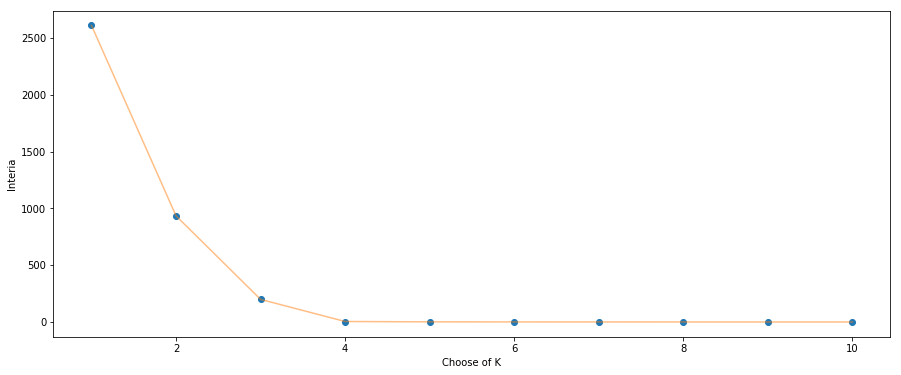

In [109]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = scores.detach().numpy()
df_empty = pd.DataFrame(columns=['first','second','third','label'])
df_empty['first'] = X[:,0]
df_empty['second'] = X[:,1]
df_empty['third'] = X[:,2]
df1 = df_empty[['first','second','third']].iloc[:,:].values  
inertia = []   

for k in range(1,11):  
    algorithm = (KMeans(n_clusters=k,  
                       init="k-means++",  
                       n_init=10,  
                       max_iter=300,  
                       tol=0.0001,  
                       random_state=111,  
                       algorithm="full"))  
    algorithm.fit(df1)  
    inertia.append(algorithm.inertia_) 
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')  
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [199]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture

In [222]:
n_clusters = 4
estimators = KMeans(n_clusters = 4)
estimators.fit(X)
yhat = estimators.predict(X)
#labele = estimators.labels_
df_empty['label'] = labele

In [223]:
n_clusters = len(df_empty['label'].value_counts())

Cluster: 0 0.0027447361 0.0029317306 0.99432355


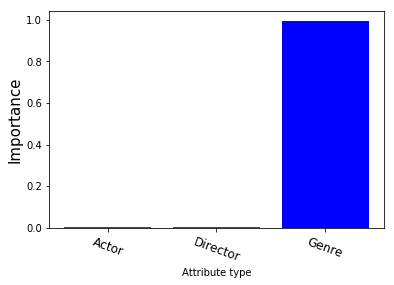

Cluster: 1 0.99976134 0.00011813612 0.00012052751


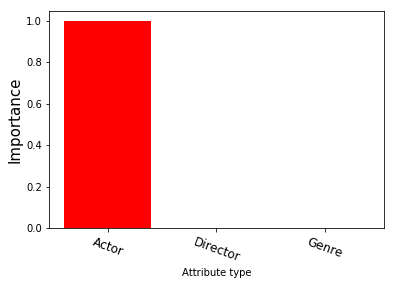

Cluster: 2 0.3313307 0.3313307 0.33733854


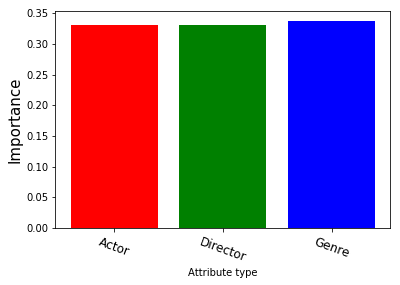

Cluster: 3 0.0007773779 0.9963497 0.0028729439


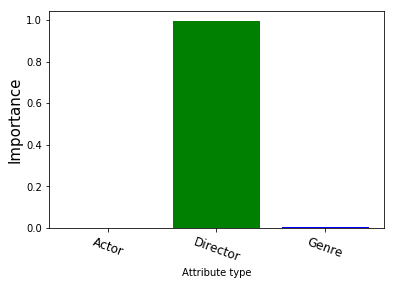

In [224]:
for i in range(n_clusters):
    print("Cluster:", i, df_empty[df_empty['label'] == i]['first'].mean(),df_empty[df_empty['label'] == i]['second'].mean(),df_empty[df_empty['label'] == i]['third'].mean())
    import matplotlib.pyplot as plt
    plt.xlabel('Attribute type')
    plt.ylabel('Importance',fontsize=15)
    name_list = ['Actor', 'Director','Genre']
    num_list = [df_empty[df_empty['label'] == i]['first'].mean(),df_empty[df_empty['label'] == i]['second'].mean(),df_empty[df_empty['label'] == i]['third'].mean()]

    hist_fig = plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
    plt.xticks(fontsize  = 'large',rotation=-20) 
    plt.savefig('cluster_'+ str(i) + '.png')

    plt.show()


In [225]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = X, labele, 38616, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

result = ts.fit_transform(data)

x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)

Starting compute t-SNE Embedding...


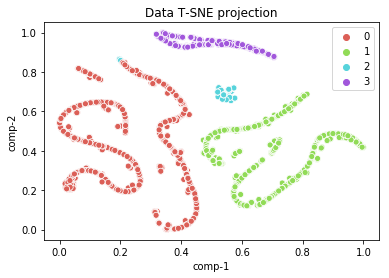

In [226]:
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data T-SNE projection")
plt.savefig('cluster_tSNEsper.png')
plt.show()


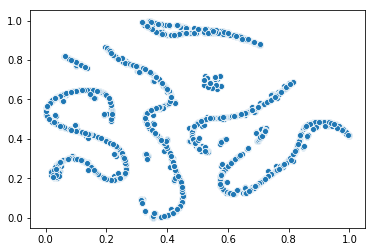

In [227]:
sns.scatterplot(result[:,0],result[:,1],legend='full')
plt.savefig('cluster_tSNENonsuper.png')
plt.show()


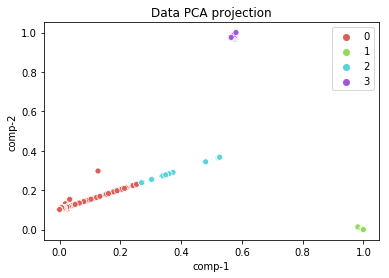

In [228]:
from sklearn.decomposition import PCA
result = PCA(n_components=2).fit_transform(data)
x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data PCA projection")
plt.savefig('cluster_pca.png')
plt.show()


In [134]:
!pip install umap-learn

In [135]:
!pip install "umap-learn[plot]"

  umap-learn 0.3.7 does not provide the extra 'plot'


In [144]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
from umap import UMAP
import umap.umap_ as umap
import umap.plot
import umap

ModuleNotFoundError: No module named 'umap.plot'

In [137]:
mapper = UMAP().fit(X)

/Users/user/.local/lib/python3.6/site-packages/umap_learn-0.3.7-py3.6.egg/umap/rp_tree.py:439: NumbaWarning: Function "make_euclidean_tree" failed type inference: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/user/.local/lib/python3.6/site-packages/umap_learn-0.3.7-py3.6.egg/umap/rp_tree.py (446)

File "../../.local/lib/python3.6/site-packages/umap_learn-0.3.7-py3.6.egg/umap/rp_tree.py", line 446:
<source missing, REPL/exec in use?>

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x1a4c3a8048>)))
[2] During: typing of call at /Users/user/.local/lib/python3.6/site-packages/umap_learn-0.3.7-py3.6.egg/umap/rp_tree.py (446)


File "../../.local

In [169]:
reslut = UMAP().fit_transform(X)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)

/Users/user/.local/lib/python3.6/site-packages/umap_learn-0.3.7-py3.6.egg/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)


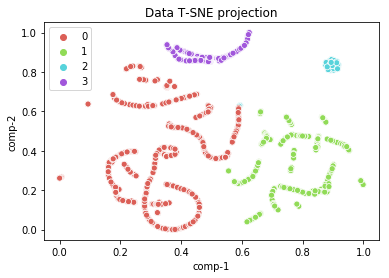

In [170]:
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = reslut[:,0]
df["comp-2"] = reslut[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data T-SNE projection")
plt.show()

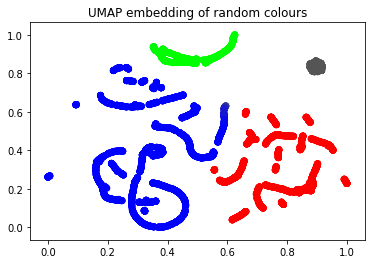

In [171]:
plt.scatter(reslut[:,0], reslut[:,1], c=X)
plt.title('UMAP embedding of random colours');